# Import necessary libraries

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder

# 1. Data Loading

In [172]:
conn = pd.read_csv('../data/zeek_preprocessed/conn.csv')
dns = pd.read_csv('../data/zeek_preprocessed/dns.csv')
ssl = pd.read_csv('../data/zeek_preprocessed/ssl.csv')
files = pd.read_csv('../data/zeek_preprocessed/files.csv')
http = pd.read_csv('../data/zeek_preprocessed/http.csv')
x509 = pd.read_csv('../data/zeek_preprocessed/x509.csv')

conn['ts'] = pd.to_datetime(conn['ts'])
dns['ts'] = pd.to_datetime(dns['ts'])
ssl['ts'] = pd.to_datetime(ssl['ts'])
files['ts'] = pd.to_datetime(files['ts'])
http['ts'] = pd.to_datetime(http['ts'])
x509['ts'] = pd.to_datetime(x509['ts'])
x509['certificate.not_valid_before'] = pd.to_datetime(x509['certificate.not_valid_before'])
x509['certificate.not_valid_after'] = pd.to_datetime(x509['certificate.not_valid_after'])

# 2. Feature engineering

Cramer's V for categorical data correlation

In [173]:
def generate_cramers_v_matrix(df):
    """
    Compute the Cramér's V matrix for categorical data correlation analysis.
    
    Parameters:
    - df: pd.DataFrame
        The input DataFrame containing categorical data.
    
    Returns:
    - chi_squared_matrix: pd.DataFrame
        A matrix containing Cramér's V values for each pair of categorical variables.
    - chi_square_results: pd.DataFrame
        A DataFrame with detailed Chi-square test results including Chi2, P-value, DF, and Cramér's V.
    """
    
    # Identify categorical columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    # Initialize matrices to store the results
    cramers_v_matrix = pd.DataFrame(columns=categorical_columns, index=categorical_columns)
    chi_square_results = pd.DataFrame(index=[f"{pair[0]} vs {pair[1]}" for pair in combinations(categorical_columns, 2)], 
                                      columns=['Chi2', 'P-value', 'DF', 'Cramer\'s V'])

    # Compute Cramér's V for each pair of categorical columns
    for pair in combinations(categorical_columns, 2):
        # Create contingency table for the pair
        contingency_table = pd.crosstab(df[pair[0]], df[pair[1]])
        
        # Perform Chi-square test
        chi2, p_value, DF, _ = chi2_contingency(contingency_table)
        
        # Calculate Cramér's V
        n = contingency_table.sum().sum()
        phi2 = chi2 / n
        r, k = contingency_table.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        
        # Calculate Cramér's V with a safeguard against division by zero
        if min(kcorr-1, rcorr-1) == 0:
            cramers_v = 0  # Set Cramér's V to 0 if there's a division by zero risk
        else:
            cramers_v = np.sqrt(phi2corr / min(kcorr-1, rcorr-1))
        # cramers_v = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
        
        # Store results in the DataFrames
        chi_square_results.loc[f"{pair[0]} vs {pair[1]}", 'Chi2'] = chi2
        chi_square_results.loc[f"{pair[0]} vs {pair[1]}", 'P-value'] = p_value
        chi_square_results.loc[f"{pair[0]} vs {pair[1]}", 'DF'] = DF
        chi_square_results.loc[f"{pair[0]} vs {pair[1]}", 'Cramer\'s V'] = cramers_v
        
        # Fill the symmetric Cramér's V matrix
        cramers_v_matrix.loc[pair[0], pair[1]] = cramers_v
        cramers_v_matrix.loc[pair[1], pair[0]] = cramers_v
    
    return cramers_v_matrix, chi_square_results

### conn.log

In [174]:
# Count the number of categorical columns
num_categorical = conn.select_dtypes(include=['object', 'category']).shape[1]

# Count the number of numerical columns
num_numerical = conn.select_dtypes(include=[np.number]).shape[1]

# Print the counts
print(f"Number of categorical columns: {num_categorical}")
print(f"Number of numerical columns: {num_numerical}")
conn

Number of categorical columns: 7
Number of numerical columns: 9


,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
0,2020-09-02 14:33:23.796334982,CMLZbu3FDJYoZwa27k,10.8.0.117,1210,8.8.8.8,53,udp,dns,0.010542,31.0,80.0,SF,Dd,1,59,1,108
1,2020-09-02 14:33:48.334928036,CgRCjV3z8dKmNVIvhb,10.8.0.117,43814,8.8.8.8,53,udp,dns,0.010908,33.0,87.0,SF,Dd,1,61,1,115
2,2020-09-02 14:33:49.757675886,CgFfWv3PUApAZUINNf,10.8.0.117,51631,8.8.8.8,53,udp,dns,0.010734,50.0,66.0,SF,Dd,1,78,1,94
3,2020-09-02 14:33:49.863610983,CIkFu02IznJPZcp1El,10.8.0.117,65449,8.8.8.8,53,udp,dns,0.010405,37.0,91.0,SF,Dd,1,65,1,119
4,2020-09-02 14:33:51.540623903,Cylq6E2mc9lVLjs8ua,10.8.0.117,63247,8.8.8.8,53,udp,dns,0.009332,40.0,80.0,SF,Dd,1,68,1,108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,2020-09-02 15:27:20.320450068,CaStVq1Pbq8KOU84Ug,10.8.0.1,3,10.8.0.117,4,icmp,NaN,NaN,NaN,NaN,OTH,NaN,1,576,0,0
219,2020-09-02 15:27:20.300543070,CokYEW2q0cjgDIE5Gi,10.8.0.117,41360,104.244.42.66,443,tcp,ssl,300.203017,3612.0,1605.0,SF,ShADadTFfRR,46,7337,27,3017
220,2020-09-02 15:05:59.255357027,CYLKkn2Rnl8tV76MRi,10.8.0.117,47850,147.32.83.230,8000,tcp,http,1808.665546,1445.0,969.0,RSTR,ShADdTatr,148,9156,123,7874
221,2020-09-02 15:31:50.362519026,CXYOR91l3zR6DkwXc4,10.8.0.117,57736,74.125.71.188,5228,tcp,NaN,0.063148,28.0,26.0,OTH,DadA,2,132,2,130


<Axes: >

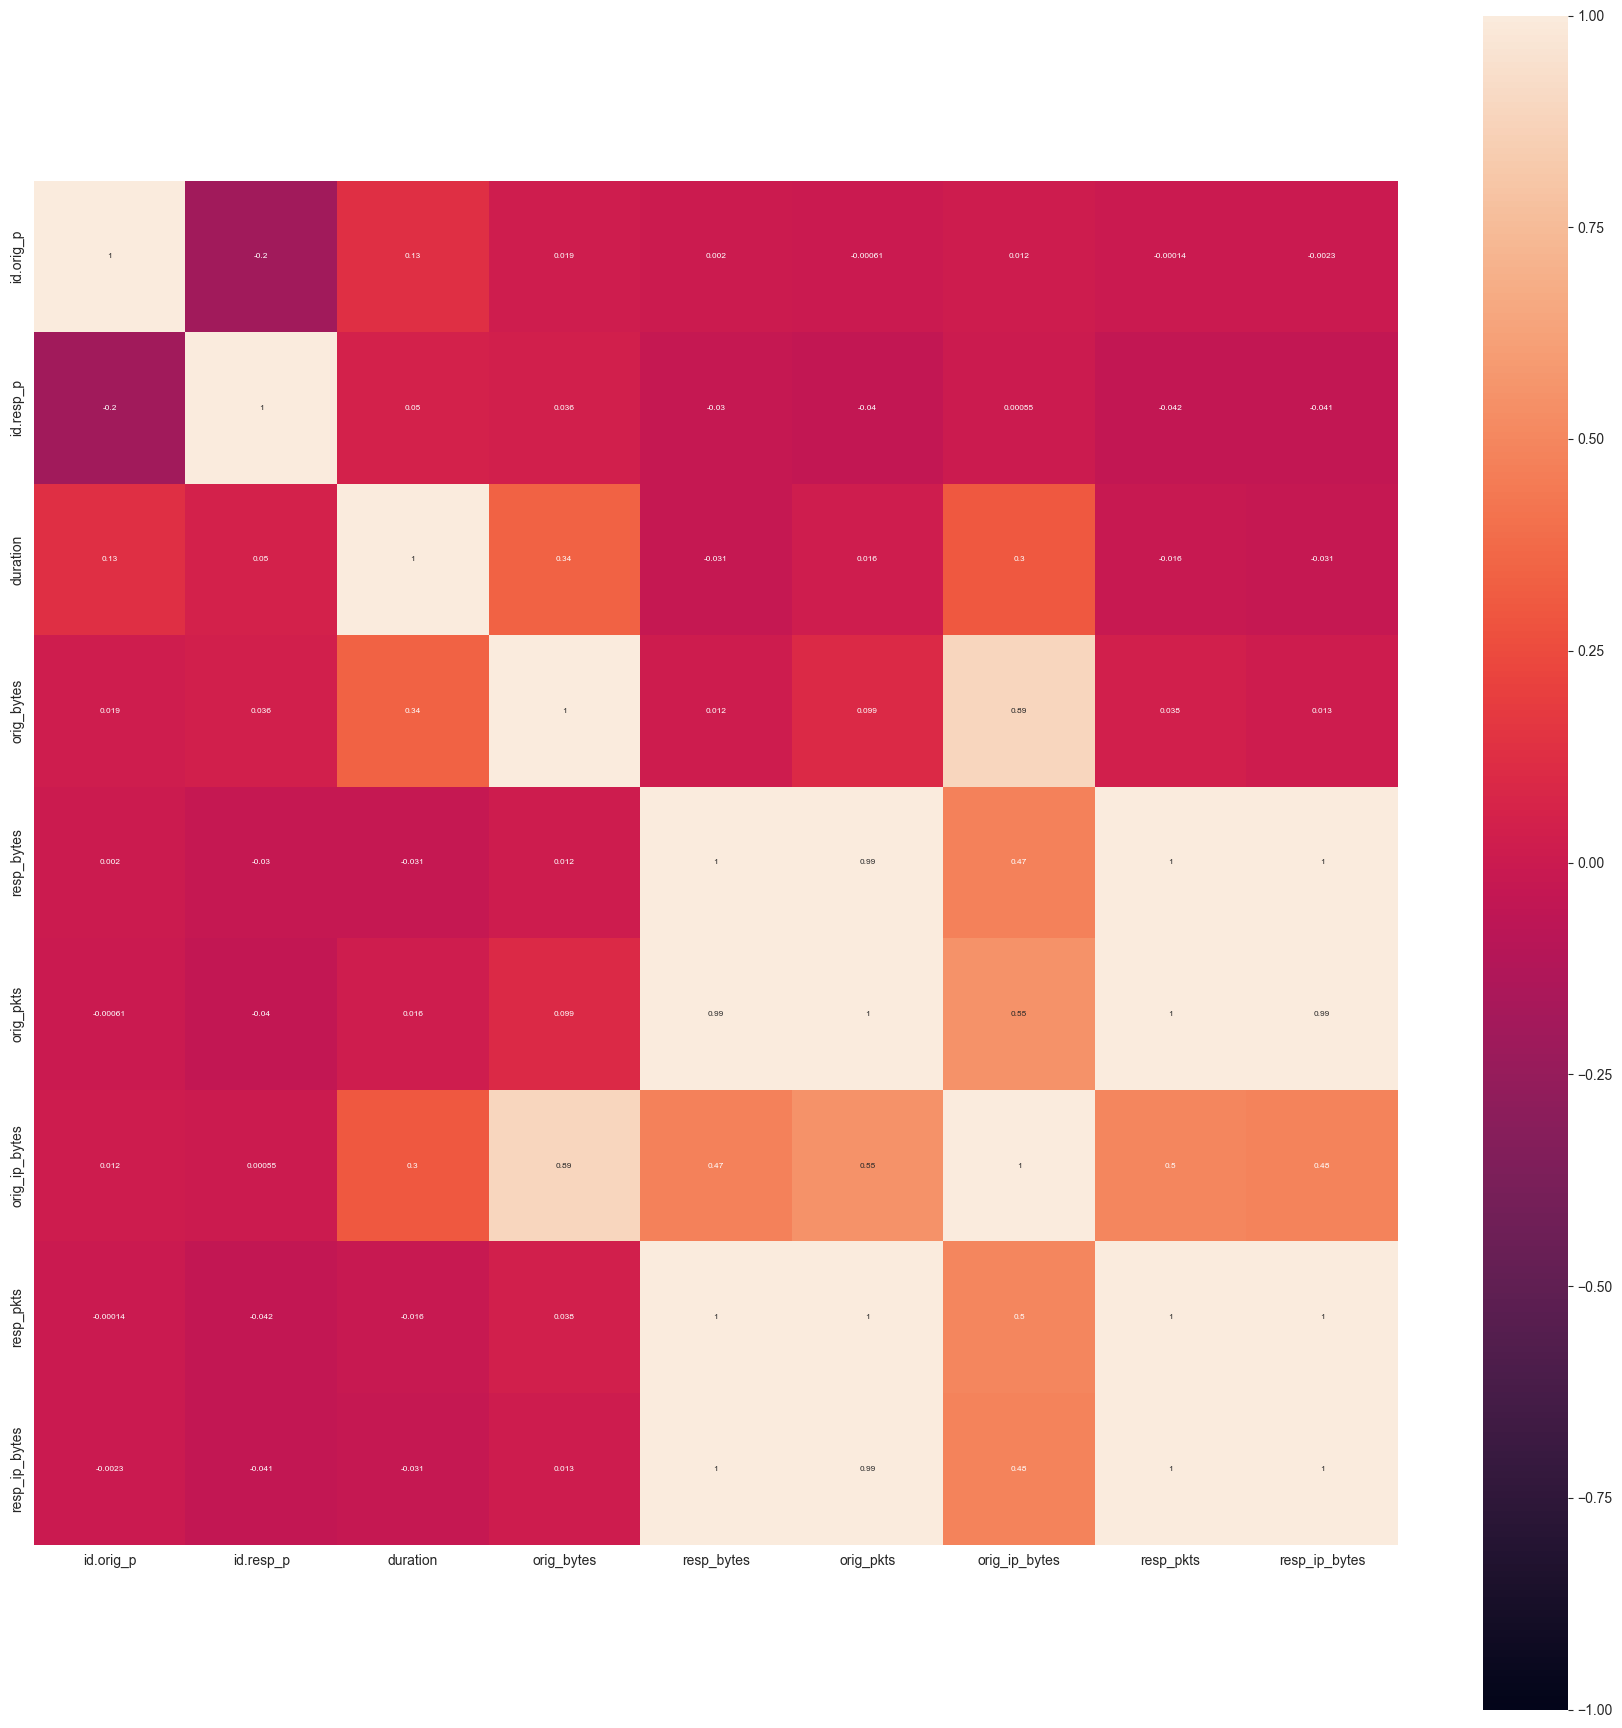

In [175]:
correlation_matrix = conn.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(22,22))
sns.heatmap(correlation_matrix, annot=True, annot_kws={'size': 6}, vmin=-1, vmax=1, square=True)

In [176]:
columns_to_remove = ['resp_pkts', 'orig_pkts', 'resp_bytes', 'orig_bytes']
conn.drop(columns=columns_to_remove, inplace=True)

C:\Users\tigro\AppData\Local\Temp\ipykernel_8244\1196448274.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cramers_v_matrix.fillna(1, inplace=True)


<Axes: >

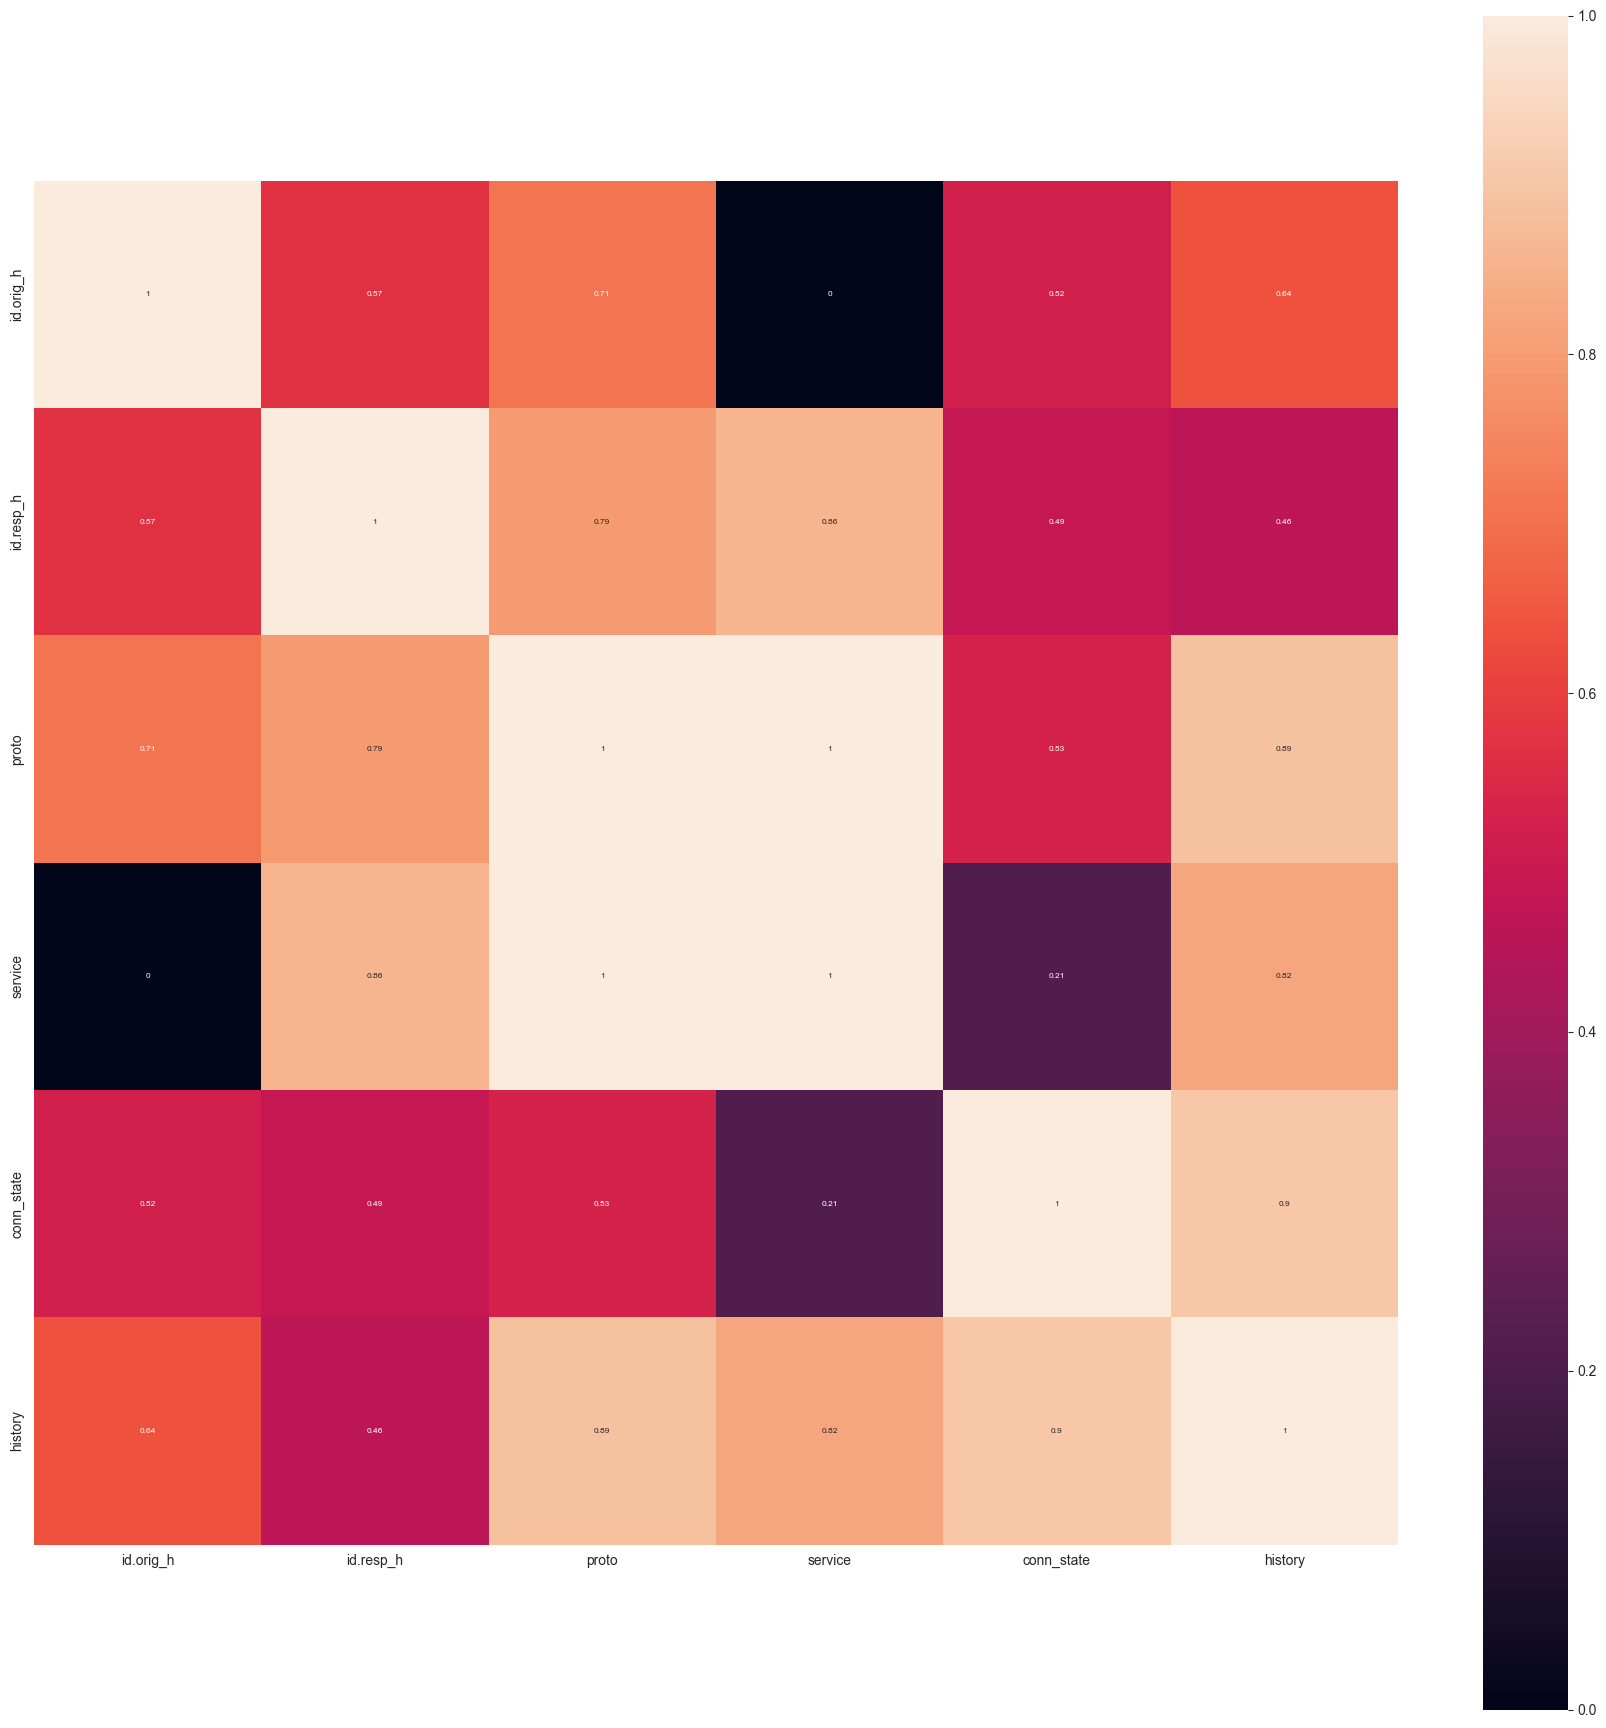

In [177]:
cramers_v_matrix,_ = generate_cramers_v_matrix(conn)

plt.figure(figsize=(22,22))
cramers_v_matrix.fillna(1, inplace=True)
cramers_v_matrix = cramers_v_matrix.drop(['uid'], axis=1)
cramers_v_matrix = cramers_v_matrix.drop(['uid'], axis=0)
sns.heatmap(cramers_v_matrix, annot=True, annot_kws={'size': 6}, vmin=0, vmax=1, square=True)

In [178]:
columns_to_remove = ['service', 'history']
conn.drop(columns=columns_to_remove, inplace=True)

### dns.log

In [179]:
# Count the number of categorical columns
num_categorical = dns.select_dtypes(include=['object', 'category']).shape[1]

# Count the number of numerical columns
num_numerical = dns.select_dtypes(include=[np.number]).shape[1]

# Print the counts
print(f"Number of categorical columns: {num_categorical}")
print(f"Number of numerical columns: {num_numerical}")
dns

Number of categorical columns: 4
Number of numerical columns: 3


,ts,uid,id.orig_p,trans_id,rtt,query,answers,TTLs
0,2020-09-02 14:33:23.796334982,CMLZbu3FDJYoZwa27k,1210,15630,0.010542,portal.fb.com,"star.c10r.facebook.com,157.240.30.18","174.000000,59.000000"
1,2020-09-02 14:33:48.334928036,CgRCjV3z8dKmNVIvhb,43814,35052,0.010908,i.instagram.com,"instagram.c10r.facebook.com,157.240.30.63","3599.000000,2.000000"
2,2020-09-02 14:33:49.757675886,CgFfWv3PUApAZUINNf,51631,55600,0.010734,scontent-prg1-1.cdninstagram.com,157.240.30.63,59.000000
3,2020-09-02 14:33:49.863610983,CIkFu02IznJPZcp1El,65449,39507,0.010405,graph.instagram.com,"instagram.c10r.facebook.com,157.240.30.63","3599.000000,30.000000"
4,2020-09-02 14:33:51.540623903,Cylq6E2mc9lVLjs8ua,63247,41491,0.009332,edge-mqtt.facebook.com,"mqtt.c10r.facebook.com,157.240.30.11","1236.000000,37.000000"
...,...,...,...,...,...,...,...,...
59,2020-09-02 15:13:09.453067064,Cyw1E94W8FfeSPczJk,60718,64687,0.018982,android.googleapis.com,216.58.201.74,299.000000
60,2020-09-02 15:13:39.478319883,C0jMGu1frh9ei1Wmqc,60710,48649,0.009136,people-pa.googleapis.com,216.58.201.106,247.000000
61,2020-09-02 15:17:56.417140961,COs0MF2BvtxqwwWZBl,16281,23329,0.009862,people-pa.googleapis.com,216.58.201.106,248.000000
62,2020-09-02 15:26:19.691025019,CovR8F24TUZtn0RYGj,1075,36482,0.009263,global.glbtls.t.co,34.102.215.127,576.000000


C:\Users\tigro\AppData\Local\Temp\ipykernel_8244\1180285252.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cramers_v_matrix.fillna(1, inplace=True)


<Axes: >

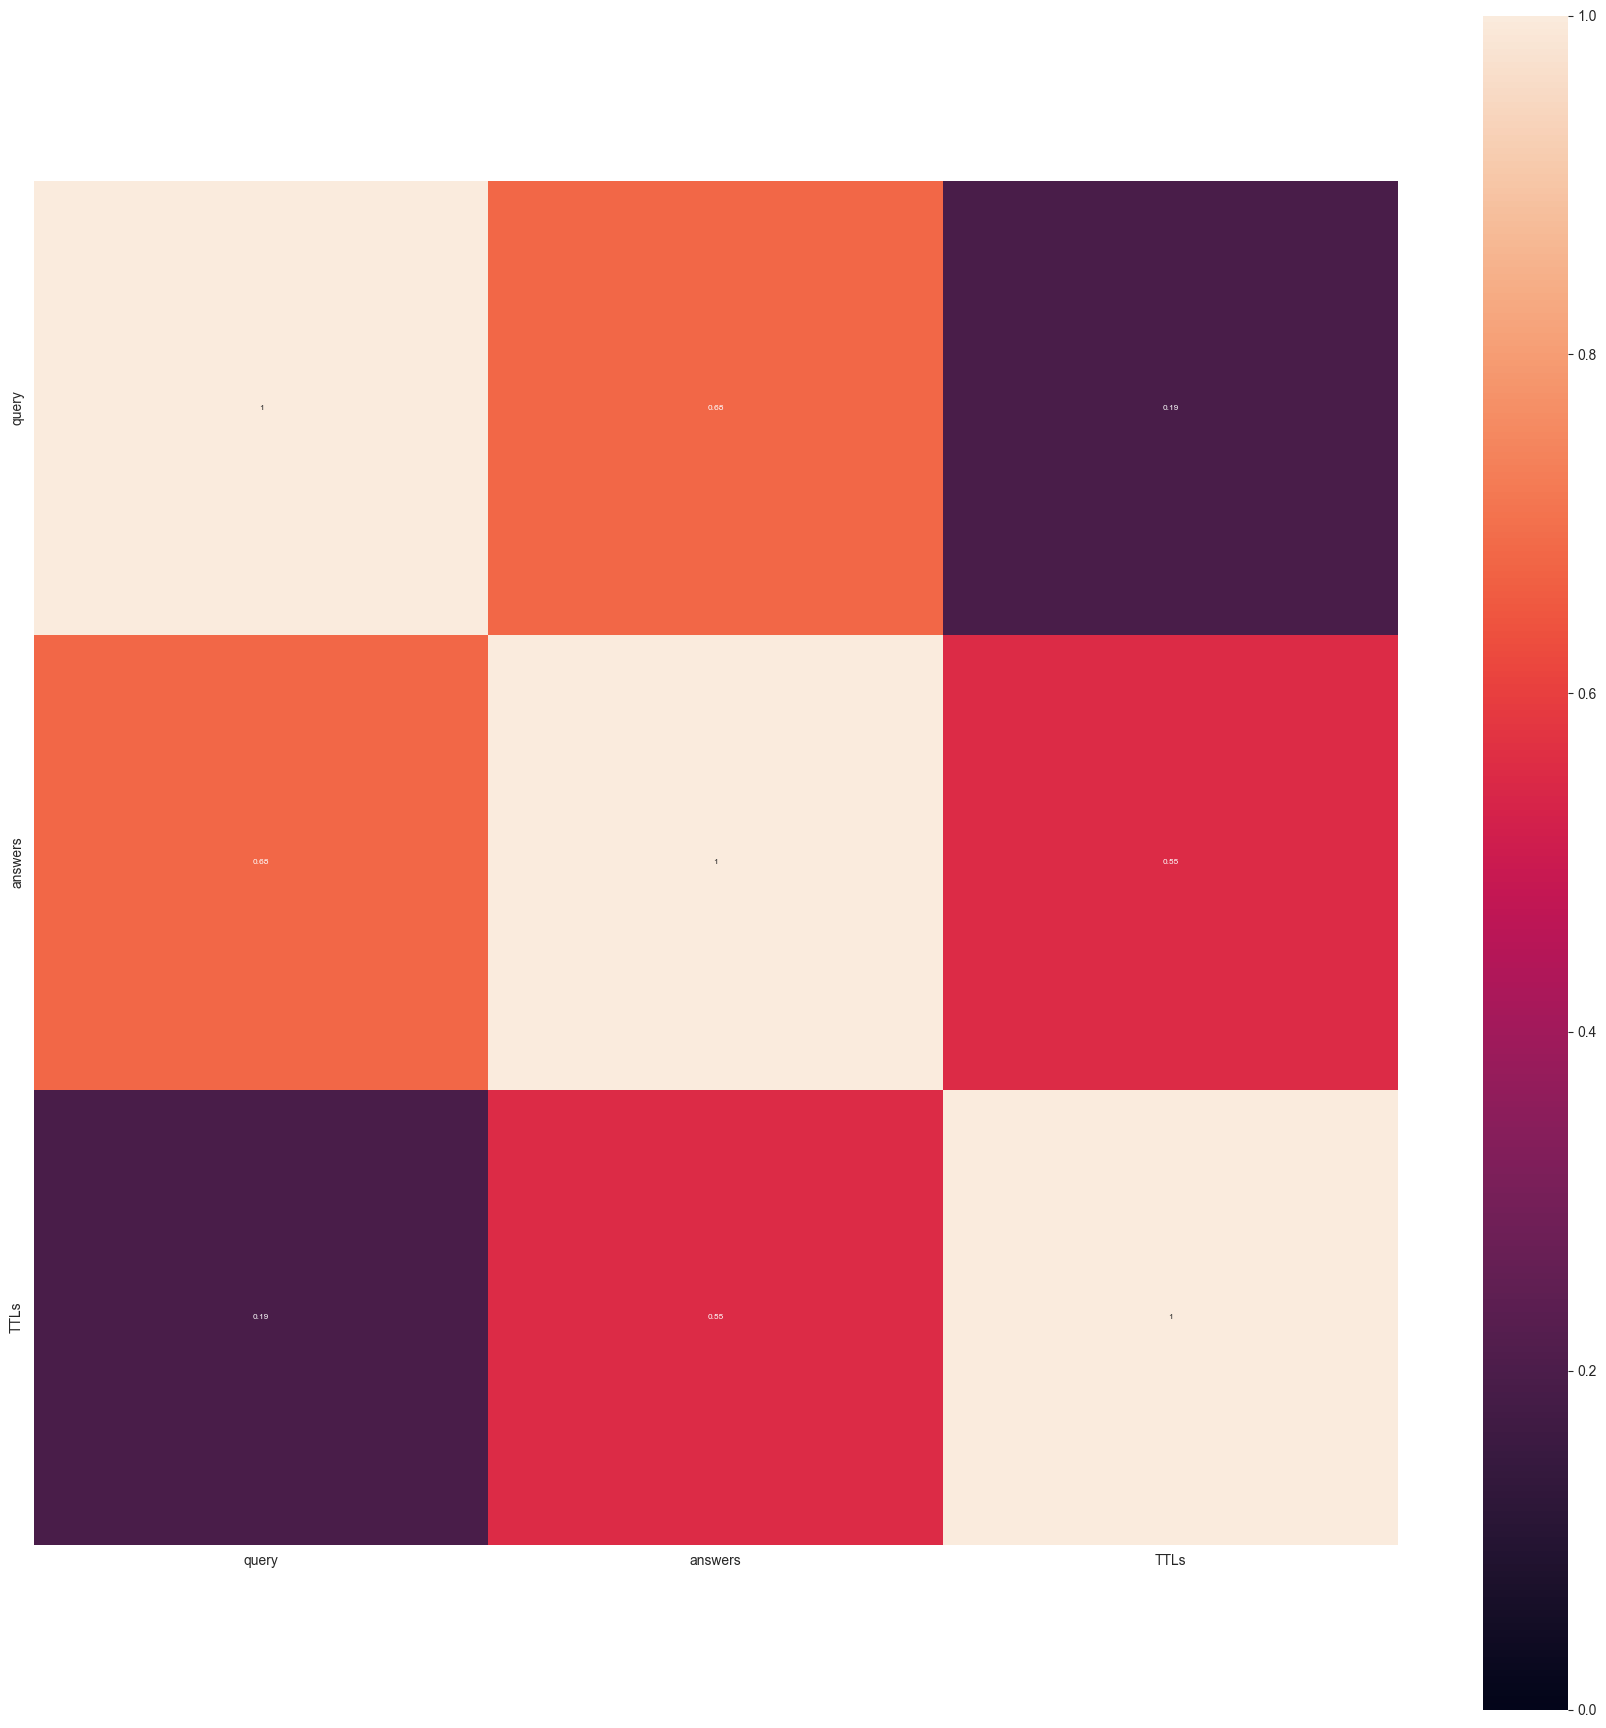

In [180]:
cramers_v_matrix,_ = generate_cramers_v_matrix(dns)

plt.figure(figsize=(22,22))
cramers_v_matrix.fillna(1, inplace=True)
cramers_v_matrix = cramers_v_matrix.drop(['uid'], axis=1)
cramers_v_matrix = cramers_v_matrix.drop(['uid'], axis=0)
sns.heatmap(cramers_v_matrix, annot=True, annot_kws={'size': 6}, vmin=0, vmax=1, square=True)

In [181]:
columns_to_remove = ['ts', 'id.orig_p', 'trans_id']
dns.drop(columns=columns_to_remove, inplace=True)

### ssl.log

In [182]:
# Count the number of categorical columns
num_categorical = ssl.select_dtypes(include=['object', 'category']).shape[1]

# Count the number of numerical columns
num_numerical = ssl.select_dtypes(include=[np.number]).shape[1]

# Print the counts
print(f"Number of categorical columns: {num_categorical}")
print(f"Number of numerical columns: {num_numerical}")
ssl

Number of categorical columns: 12
Number of numerical columns: 2


,ts,uid,id.orig_p,id.resp_h,id.resp_p,version,cipher,curve,server_name,resumed,next_protocol,established,cert_chain_fuids,subject,issuer
0,2020-09-02 14:33:48.338402033,CgnCcKyQn6Fuvtaaa,33952,157.240.30.63,443,unknown-64282,TLS_AES_128_GCM_SHA256,x25519,i.instagram.com,T,NaN,T,NaN,NaN,NaN
1,2020-09-02 14:33:49.760056019,CyaZhP168fSnjEW4i,33954,157.240.30.63,443,unknown-64282,TLS_AES_128_GCM_SHA256,x25519,scontent-prg1-1.cdninstagram.com,T,NaN,T,NaN,NaN,NaN
2,2020-09-02 14:33:49.785082102,C1joeV1VXsHCLjiswg,33956,157.240.30.63,443,unknown-64282,TLS_AES_128_GCM_SHA256,x25519,scontent-prg1-1.cdninstagram.com,T,NaN,T,NaN,NaN,NaN
3,2020-09-02 14:33:49.816934109,CplZRBVCFLcGq4Dbl,33958,157.240.30.63,443,unknown-64282,TLS_AES_128_GCM_SHA256,x25519,scontent-prg1-1.cdninstagram.com,T,NaN,T,NaN,NaN,NaN
4,2020-09-02 14:33:49.826136112,C05gpYcCZjI5tZ4m5,33960,157.240.30.63,443,unknown-64282,TLS_AES_128_GCM_SHA256,x25519,scontent-prg1-1.cdninstagram.com,T,NaN,T,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,2020-09-02 15:13:56.091309071,CoqeK14slRRWT3jSG3,41734,216.58.201.106,443,TLSv13,TLS_AES_128_GCM_SHA256,x25519,people-pa.googleapis.com,F,NaN,T,NaN,NaN,NaN
74,2020-09-02 15:26:19.705396891,Cmz3aX3s2GpoaPURW,54090,34.102.215.127,443,TLSv13,TLS_AES_128_GCM_SHA256,x25519,global.glbtls.t.co,T,NaN,T,NaN,NaN,NaN
75,2020-09-02 15:26:19.895692110,Ci1SH62mLUPecPJx5d,38796,104.244.42.195,443,TLSv12,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,NaN,probe.twitter.com,T,http/1.1,T,NaN,NaN,NaN
76,2020-09-02 15:26:20.073468924,CupYkjJ1BXaXaZk94,54094,34.102.215.127,443,TLSv13,TLS_AES_128_GCM_SHA256,x25519,global.glbtls.t.co,T,NaN,T,NaN,NaN,NaN


C:\Users\tigro\AppData\Local\Temp\ipykernel_8244\4239985443.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cramers_v_matrix.fillna(1, inplace=True)


<Axes: >

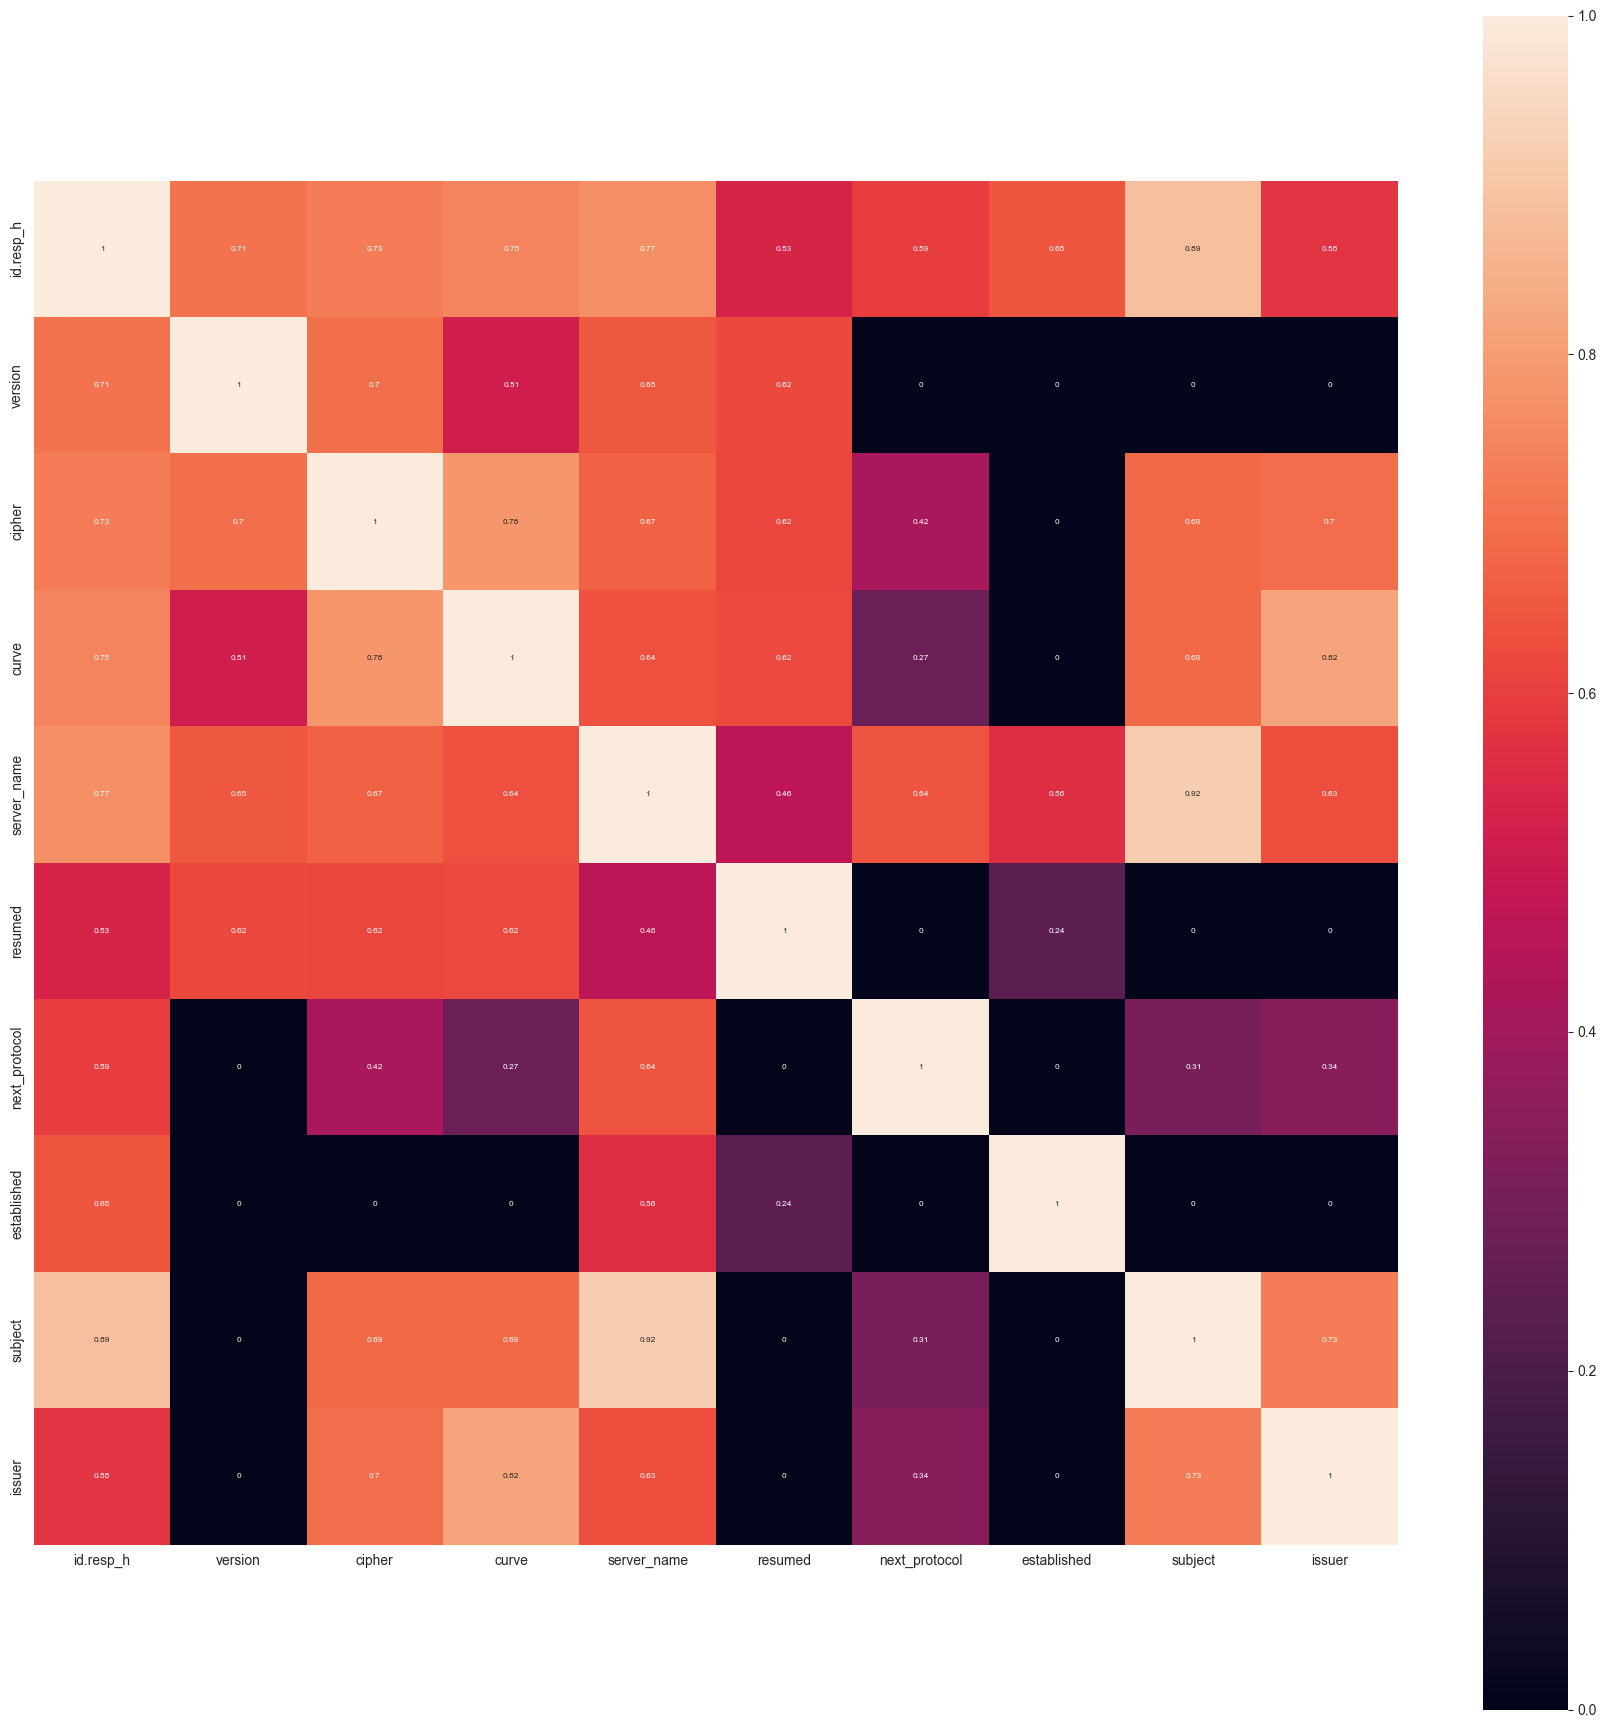

In [183]:
cramers_v_matrix,_ = generate_cramers_v_matrix(ssl)

plt.figure(figsize=(22,22))
cramers_v_matrix.fillna(1, inplace=True)
cramers_v_matrix = cramers_v_matrix.drop(['uid'], axis=1)
cramers_v_matrix = cramers_v_matrix.drop(['uid'], axis=0)
cramers_v_matrix = cramers_v_matrix.drop(['cert_chain_fuids'], axis=1)
cramers_v_matrix = cramers_v_matrix.drop(['cert_chain_fuids'], axis=0)
sns.heatmap(cramers_v_matrix, annot=True, annot_kws={'size': 6}, vmin=0, vmax=1, square=True)

In [184]:
columns_to_remove = ['ts', 'id.orig_p', 'id.resp_h', 'id.resp_p', 'cipher', 'curve', 'subject', 'issuer']
ssl.drop(columns=columns_to_remove, inplace=True)

In [185]:
ssl

,uid,version,server_name,resumed,next_protocol,established,cert_chain_fuids
0,CgnCcKyQn6Fuvtaaa,unknown-64282,i.instagram.com,T,NaN,T,NaN
1,CyaZhP168fSnjEW4i,unknown-64282,scontent-prg1-1.cdninstagram.com,T,NaN,T,NaN
2,C1joeV1VXsHCLjiswg,unknown-64282,scontent-prg1-1.cdninstagram.com,T,NaN,T,NaN
3,CplZRBVCFLcGq4Dbl,unknown-64282,scontent-prg1-1.cdninstagram.com,T,NaN,T,NaN
4,C05gpYcCZjI5tZ4m5,unknown-64282,scontent-prg1-1.cdninstagram.com,T,NaN,T,NaN
...,...,...,...,...,...,...,...
73,CoqeK14slRRWT3jSG3,TLSv13,people-pa.googleapis.com,F,NaN,T,NaN
74,Cmz3aX3s2GpoaPURW,TLSv13,global.glbtls.t.co,T,NaN,T,NaN
75,Ci1SH62mLUPecPJx5d,TLSv12,probe.twitter.com,T,http/1.1,T,NaN
76,CupYkjJ1BXaXaZk94,TLSv13,global.glbtls.t.co,T,NaN,T,NaN


### http.log

In [186]:
# Count the number of categorical columns
num_categorical = http.select_dtypes(include=['object', 'category']).shape[1]

# Count the number of numerical columns
num_numerical = http.select_dtypes(include=[np.number]).shape[1]

# Print the counts
print(f"Number of categorical columns: {num_categorical}")
print(f"Number of numerical columns: {num_numerical}")
http

Number of categorical columns: 8
Number of numerical columns: 6


,ts,uid,id.orig_p,id.resp_h,id.resp_p,trans_depth,method,host,uri,user_agent,request_body_len,response_body_len,status_code,status_msg,resp_fuids
0,2020-09-02 14:33:23.810384989,CBPoVA3CEo9RnTQNDj,58290,157.240.30.18,80,1,GET,portal.fb.com,/mobile/status.php,Facebook,0,0,204.0,No Content,NaN
1,2020-09-02 14:36:16.844291925,CriN9h1d6hCNTMi3P6,38680,13.107.4.52,80,1,GET,www.msftconnecttest.com,/connecttest.txt?n=1599057376803,okhttp/3.11.0,0,22,200.0,OK,FD0bxc2b2RRcwMJgR6
2,2020-09-02 14:39:00.430397987,CKwfPy2GoRYlUeD35i,47782,147.32.83.230,8000,1,GET,147.32.83.230,/socket.io/?model=unknown&EIO=3&id=3ad69a3e675...,Dalvik/2.1.0 (Linux; U; Android 8.0.0; unknown...,0,101,200.0,OK,Fn4Nyq2uspF7NKz5Sd
3,2020-09-02 14:39:03.634990931,CKwfPy2GoRYlUeD35i,47782,147.32.83.230,8000,2,GET,147.32.83.230,/socket.io/?release=8.0.0&model=unknown&EIO=3&...,Dalvik/2.1.0 (Linux; U; Android 8.0.0; unknown...,0,5,200.0,OK,FFgr86DuOh95cXgD2
4,2020-09-02 14:39:03.647546053,CKwfPy2GoRYlUeD35i,47782,147.32.83.230,8000,3,GET,147.32.83.230,/socket.io/?release=8.0.0&model=unknown&EIO=3&...,Dalvik/2.1.0 (Linux; U; Android 8.0.0; unknown...,0,4,200.0,OK,FBfRJY23EJDBjouIgi
5,2020-09-02 14:46:14.230858088,Cpl4DO1V4VtiWE0oBj,47800,147.32.83.230,8000,1,GET,147.32.83.230,/socket.io/?model=unknown&EIO=3&id=3ad69a3e675...,Dalvik/2.1.0 (Linux; U; Android 8.0.0; unknown...,0,101,200.0,OK,FjFdMuSXbZHaDExq6
6,2020-09-02 14:46:14.828830004,Cpl4DO1V4VtiWE0oBj,47800,147.32.83.230,8000,2,GET,147.32.83.230,/socket.io/?release=8.0.0&model=unknown&EIO=3&...,Dalvik/2.1.0 (Linux; U; Android 8.0.0; unknown...,0,5,200.0,OK,Fw9Tz43sdEHYfJfWFj
7,2020-09-02 14:46:14.852785110,Cpl4DO1V4VtiWE0oBj,47800,147.32.83.230,8000,3,GET,147.32.83.230,/socket.io/?release=8.0.0&model=unknown&EIO=3&...,Dalvik/2.1.0 (Linux; U; Android 8.0.0; unknown...,0,4,200.0,OK,FXvc931jVqQOqy9Hwl
8,2020-09-02 14:39:03.638447046,C0Uxcf30mJ2Lq5wbX,47786,147.32.83.230,8000,1,GET,147.32.83.230,/socket.io/?release=8.0.0&model=unknown&EIO=3&...,okhttp/3.5.0,0,0,101.0,Switching Protocols,NaN
9,2020-09-02 14:46:14.831793070,CNPVre20YbYQSMf7Ke,47802,147.32.83.230,8000,1,GET,147.32.83.230,/socket.io/?release=8.0.0&model=unknown&EIO=3&...,okhttp/3.5.0,0,0,101.0,Switching Protocols,NaN


<Axes: >

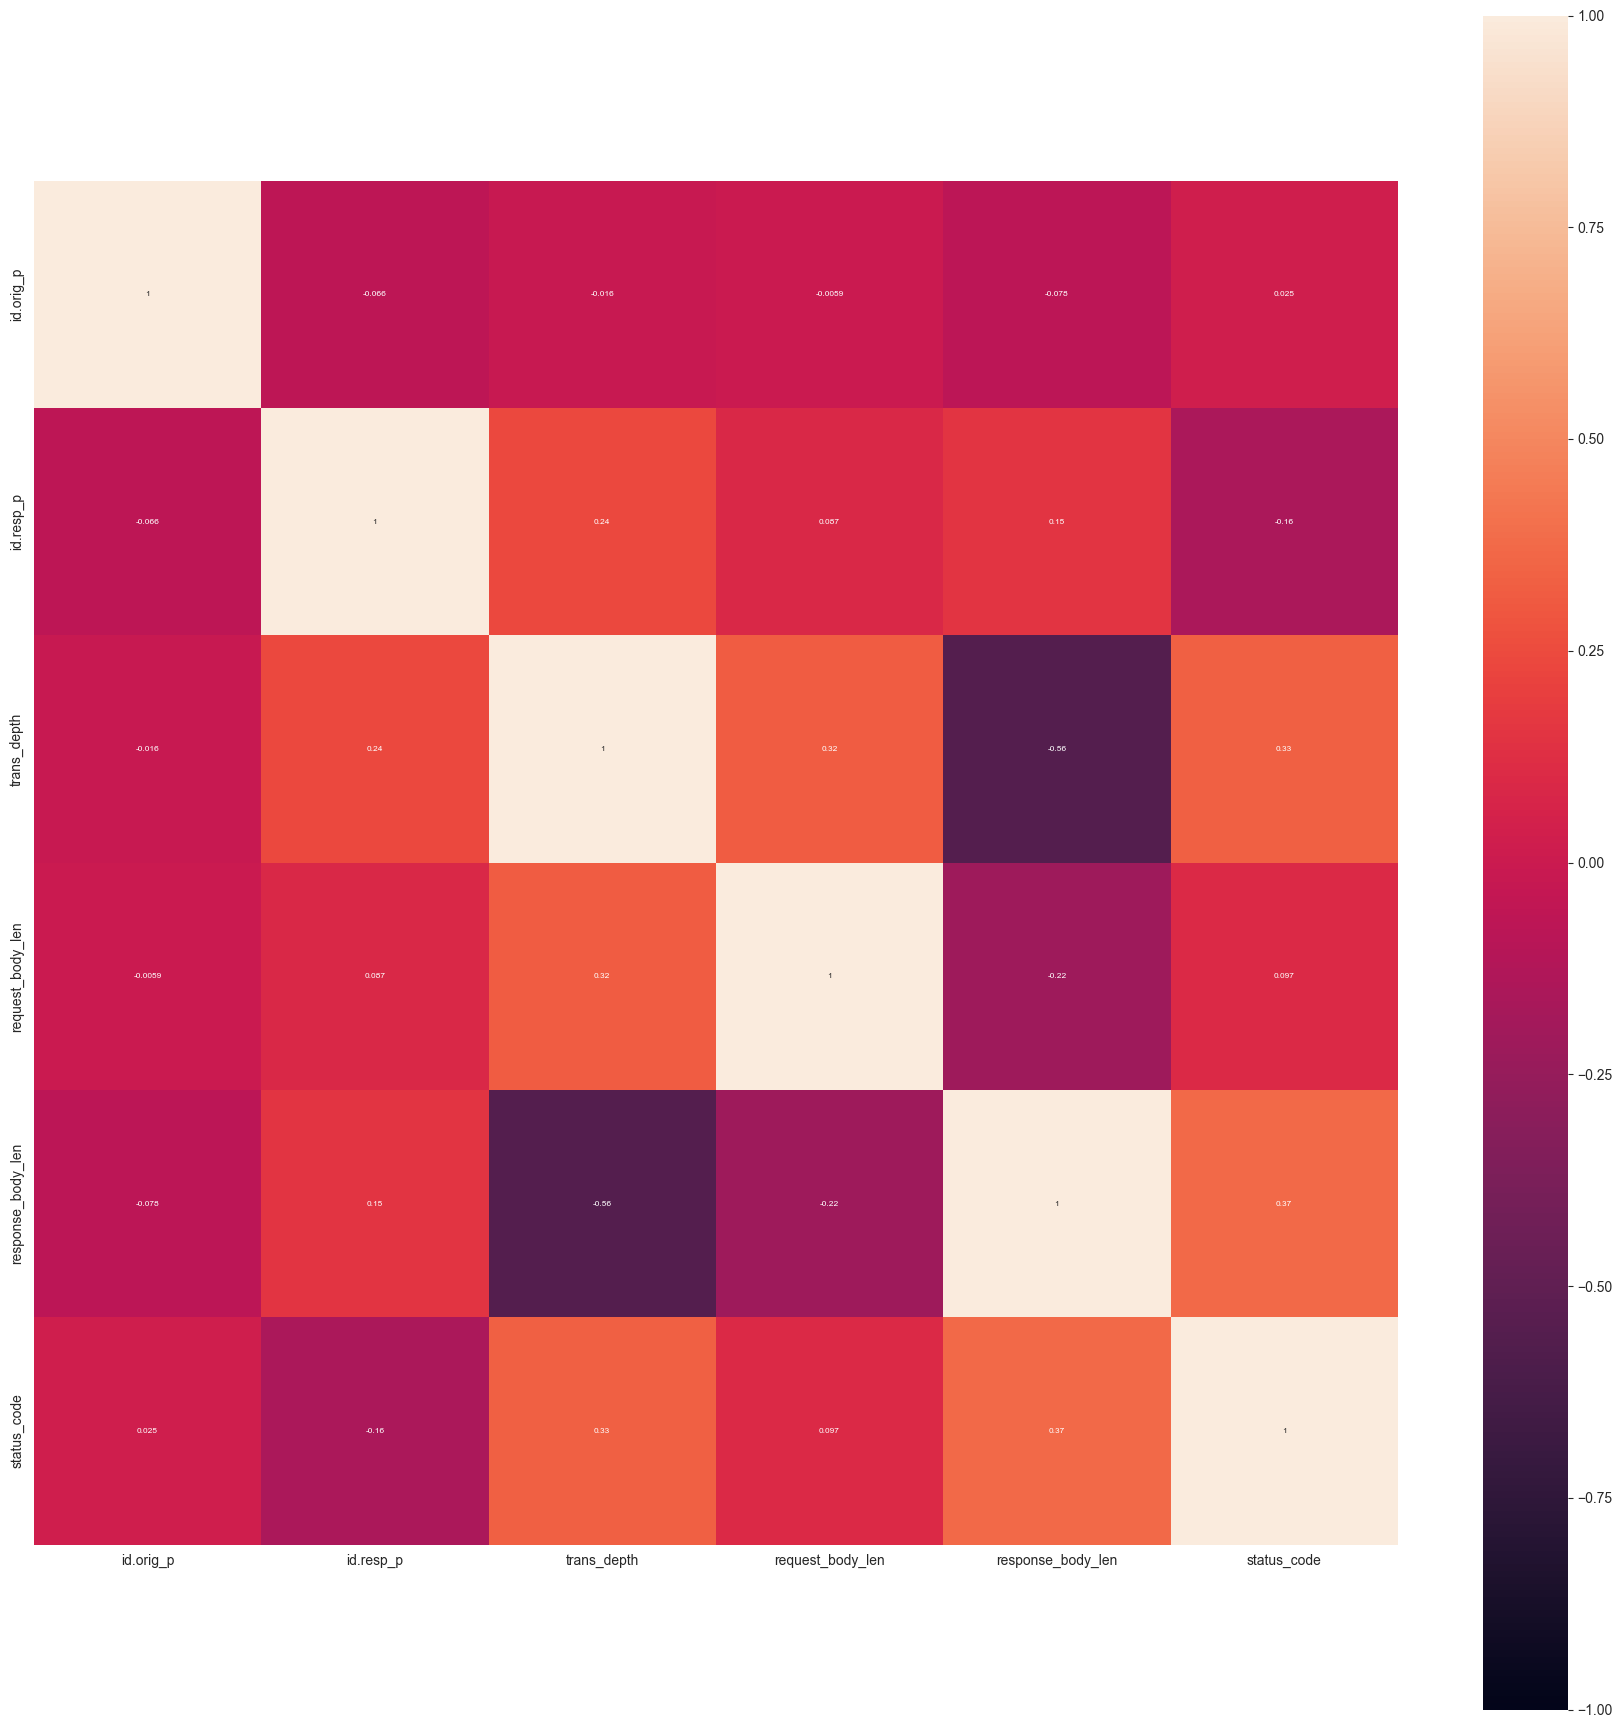

In [187]:
correlation_matrix = http.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(22,22))
sns.heatmap(correlation_matrix, annot=True, annot_kws={'size': 6}, vmin=-1, vmax=1, square=True)

C:\Users\tigro\AppData\Local\Temp\ipykernel_8244\3218903500.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cramers_v_matrix.fillna(1, inplace=True)


<Axes: >

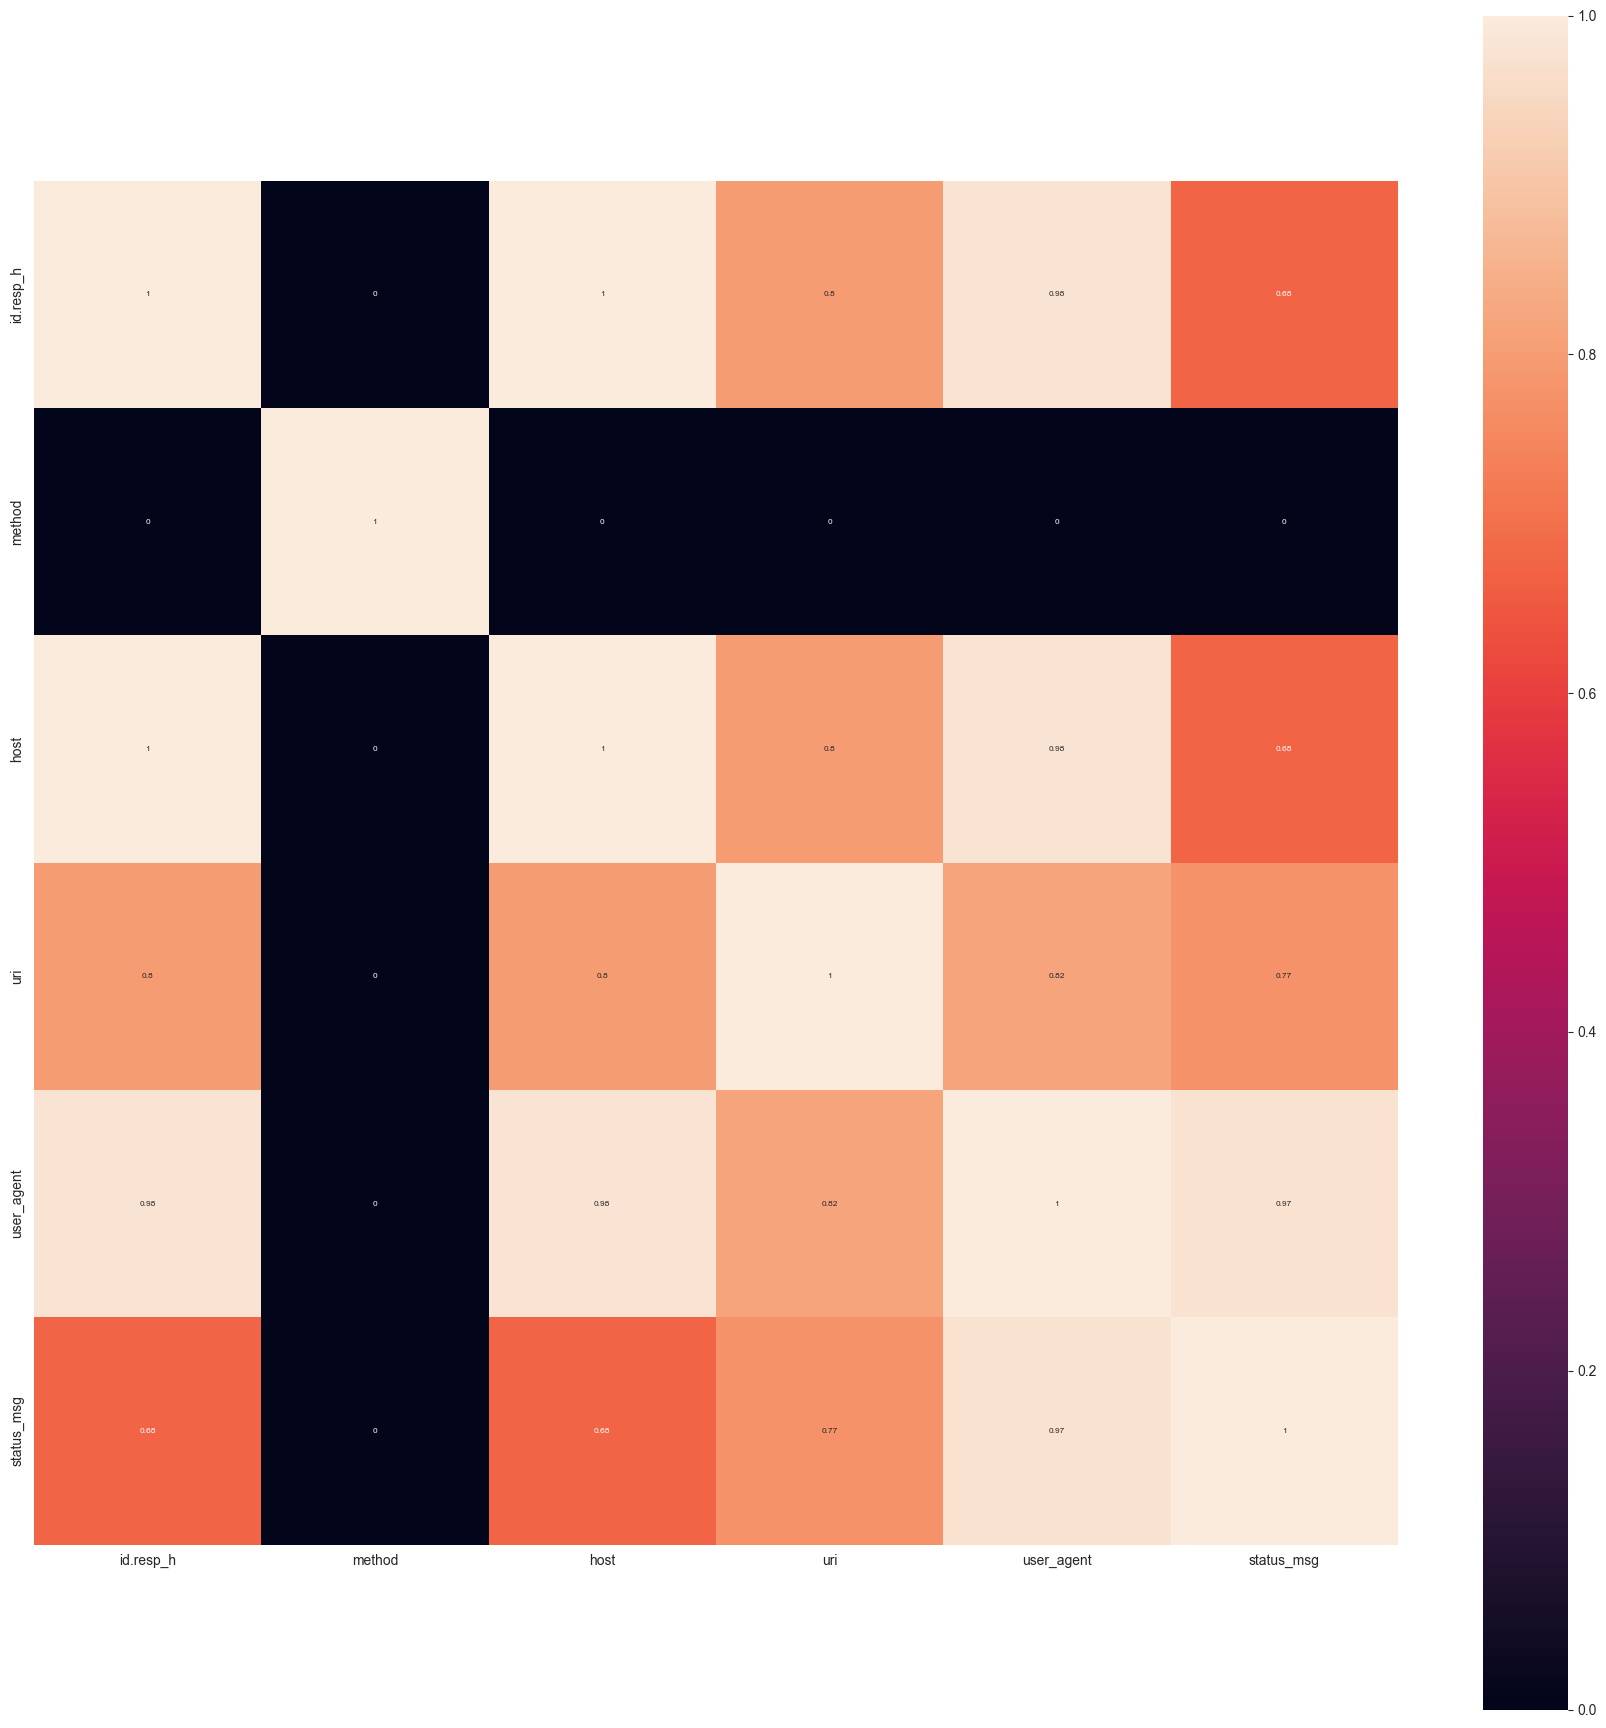

In [188]:
cramers_v_matrix,_ = generate_cramers_v_matrix(http)

plt.figure(figsize=(22,22))
cramers_v_matrix.fillna(1, inplace=True)
cramers_v_matrix = cramers_v_matrix.drop(['uid'], axis=1)
cramers_v_matrix = cramers_v_matrix.drop(['uid'], axis=0)
cramers_v_matrix = cramers_v_matrix.drop(['resp_fuids'], axis=1)
cramers_v_matrix = cramers_v_matrix.drop(['resp_fuids'], axis=0)
sns.heatmap(cramers_v_matrix, annot=True, annot_kws={'size': 6}, vmin=0, vmax=1, square=True)

In [189]:
columns_to_remove = ['ts', 'id.orig_p', 'id.resp_h', 'id.resp_p', 'method', 'user_agent']
http.drop(columns=columns_to_remove, inplace=True)

### files.log

In [190]:
# Count the number of categorical columns
num_categorical = files.select_dtypes(include=['object', 'category']).shape[1]

# Count the number of numerical columns
num_numerical = files.select_dtypes(include=[np.number]).shape[1]

# Print the counts
print(f"Number of categorical columns: {num_categorical}")
print(f"Number of numerical columns: {num_numerical}")
files

Number of categorical columns: 11
Number of numerical columns: 2


,ts,fuid,tx_hosts,rx_hosts,conn_uids,source,analyzers,mime_type,is_orig,seen_bytes,total_bytes,md5,sha1,sha256
0,2020-09-02 14:33:51.558053017,F11cB51wbjfFUg2Hqk,157.240.30.11,10.8.0.117,CYaRbd1LgVHyMi0os7,SSL,"SHA1,MD5,X509,SHA256",application/x-x509-user-cert,F,1579,NaN,e19002ec2bb5c0e7948cd6d78135affb,804630a5608b98ceecacfef4f4c848abe4519046,262c85b7e575e465100dc68eb7df059f0f705fd59e0998...
1,2020-09-02 14:33:51.558053017,FmMSzw1GvTD6uTW1d9,157.240.30.11,10.8.0.117,CYaRbd1LgVHyMi0os7,SSL,"SHA1,MD5,X509,SHA256",application/x-x509-ca-cert,F,1205,NaN,aaee5cf8b0d8596d2e0cbe67421cf7db,a031c46782e6e6c662c2c87c76da9aa62ccabd8e,19400be5b7a31fb733917700789d2f0a2471c0c9d506c0...
2,2020-09-02 14:34:15.589654922,FGkGth3S2vgqsSOeW9,157.240.30.34,10.8.0.117,CE2v1V1PiJwfenwq22,SSL,"SHA1,MD5,X509,SHA256",application/x-x509-user-cert,F,1579,NaN,e19002ec2bb5c0e7948cd6d78135affb,804630a5608b98ceecacfef4f4c848abe4519046,262c85b7e575e465100dc68eb7df059f0f705fd59e0998...
3,2020-09-02 14:34:15.589654922,FpI5qi1NT6HlRITfm4,157.240.30.34,10.8.0.117,CE2v1V1PiJwfenwq22,SSL,"SHA1,MD5,X509,SHA256",application/x-x509-ca-cert,F,1205,NaN,aaee5cf8b0d8596d2e0cbe67421cf7db,a031c46782e6e6c662c2c87c76da9aa62ccabd8e,19400be5b7a31fb733917700789d2f0a2471c0c9d506c0...
4,2020-09-02 14:34:59.079447031,FU4lIF474GDFf2hycj,69.171.250.20,10.8.0.117,CnCVN6i60NAbKmFxl,SSL,"SHA1,MD5,X509,SHA256",application/x-x509-user-cert,F,1579,NaN,e19002ec2bb5c0e7948cd6d78135affb,804630a5608b98ceecacfef4f4c848abe4519046,262c85b7e575e465100dc68eb7df059f0f705fd59e0998...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2020-09-02 15:03:10.475212097,FcPgxI2DlGsDq4Iooe,147.32.83.230,10.8.0.117,CUhwFI2YjMkHyGju97,HTTP,"SHA1,MD5",NaN,F,4,4.0,c94b90fc9bdacb4b8efa79f71455723a,7b92da47b53515e492370f44792fbd37c1b948ce,NaN
66,2020-09-02 15:03:35.527549982,F0Jblz1wtu9YAE7sf8,10.8.0.117,147.32.83.230,CIrUMN3KNrQM1GRnU7,HTTP,"SHA1,MD5",NaN,T,4,4.0,929b5a8e73ca9450f2fa8b3e4b76b9e0,8ac2a8ffc06bf6dec00490114323704ebda01dd2,NaN
67,2020-09-02 15:05:59.249593973,FCuPUX3P4dyRQdf973,147.32.83.230,10.8.0.117,C9x7S83q8VCbuVz4wl,HTTP,"SHA1,MD5",NaN,F,101,101.0,8db63e8db948313c60e5a2d703e86cf9,be4b038a23783e1ca913678e05804a7d458a0242,NaN
68,2020-09-02 15:05:59.261938094,FGApK81eAeQWObJDG6,147.32.83.230,10.8.0.117,C9x7S83q8VCbuVz4wl,HTTP,"SHA1,MD5",NaN,F,5,5.0,7af80a3ef50f8ab70677275473b1b1b8,bbddc27df3428bce641ace40dbd9afc0cd9ad583,NaN


C:\Users\tigro\AppData\Local\Temp\ipykernel_8244\3146701548.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cramers_v_matrix.fillna(1, inplace=True)


<Axes: >

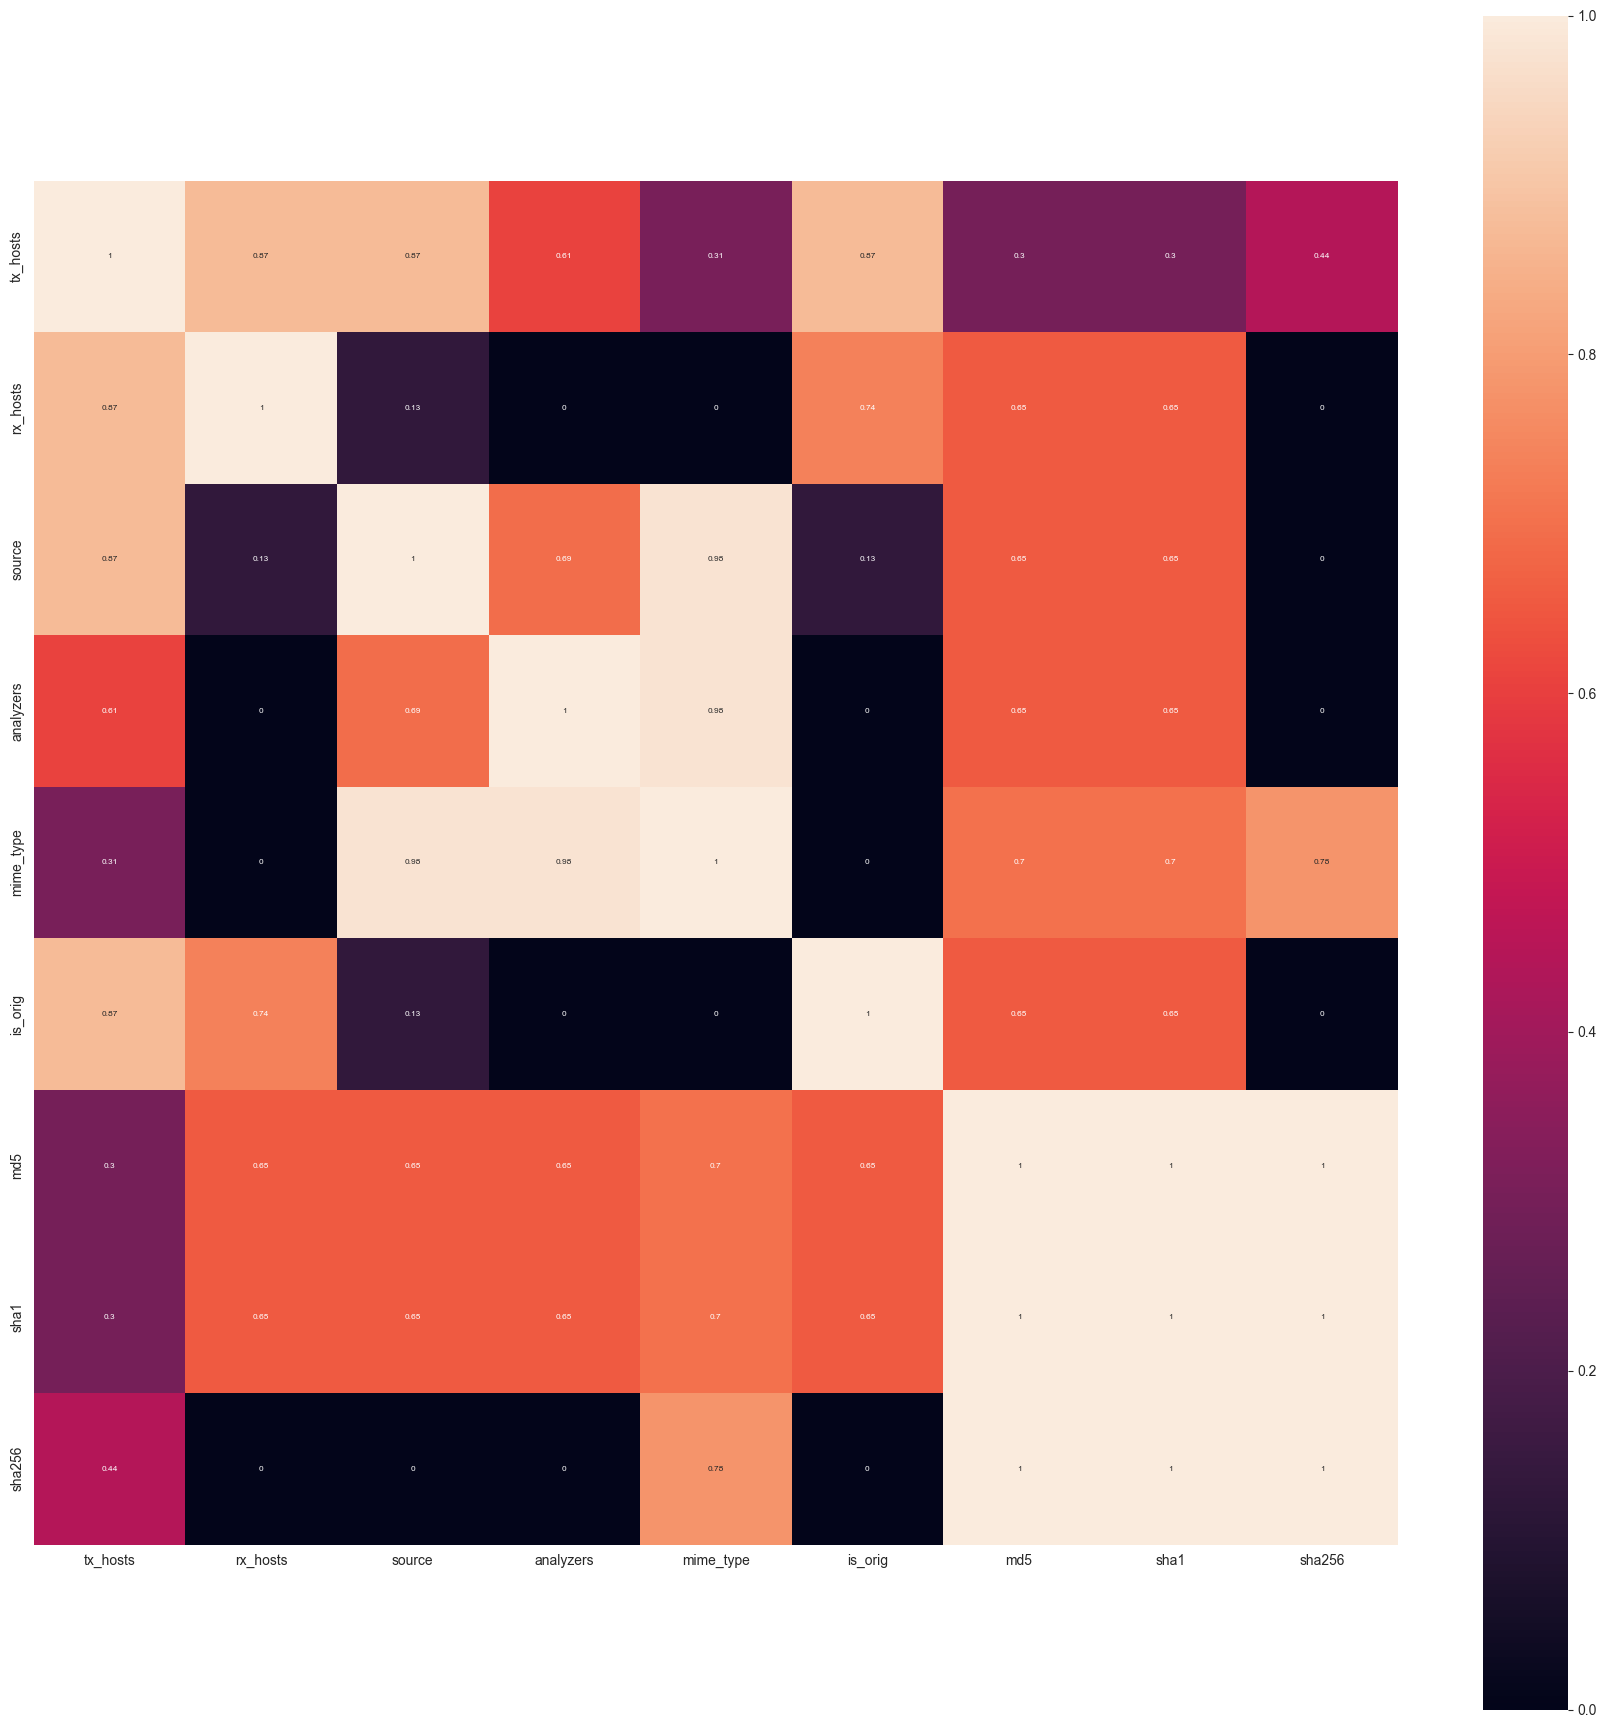

In [191]:
cramers_v_matrix,_ = generate_cramers_v_matrix(files)

plt.figure(figsize=(22,22))
cramers_v_matrix.fillna(1, inplace=True)
cramers_v_matrix = cramers_v_matrix.drop(['fuid'], axis=1)
cramers_v_matrix = cramers_v_matrix.drop(['fuid'], axis=0)
cramers_v_matrix = cramers_v_matrix.drop(['conn_uids'], axis=1)
cramers_v_matrix = cramers_v_matrix.drop(['conn_uids'], axis=0)
sns.heatmap(cramers_v_matrix, annot=True, annot_kws={'size': 6}, vmin=0, vmax=1, square=True)

In [192]:
columns_to_remove = ['ts', 'md5', 'sha1', 'sha256', 'mime_type']
files.drop(columns=columns_to_remove, inplace=True)

### x509.log

In [193]:
# Count the number of categorical columns
num_categorical = x509.select_dtypes(include=['object', 'category']).shape[1]

# Count the number of numerical columns
num_numerical = x509.select_dtypes(include=[np.number]).shape[1]

# Print the counts
print(f"Number of categorical columns: {num_categorical}")
print(f"Number of numerical columns: {num_numerical}")
x509

Number of categorical columns: 7
Number of numerical columns: 1


,ts,id,certificate.serial,certificate.subject,certificate.issuer,certificate.not_valid_before,certificate.not_valid_after,certificate.key_alg,certificate.key_type,certificate.key_length,san.dns
0,2020-09-02 14:33:51.558053017,F11cB51wbjfFUg2Hqk,01C1AC2FB17829C72707395E7EF8CDB3,"CN=*.facebook.com,O=Facebook\\, Inc.,L=Menlo P...","CN=DigiCert SHA2 High Assurance Server CA,OU=w...",2020-07-20 22:00:00,2020-10-12 10:00:00,id-ecPublicKey,ecdsa,256,"*.facebook.com,*.facebook.net,*.fbcdn.net,*.fb..."
1,2020-09-02 14:34:15.589654922,FGkGth3S2vgqsSOeW9,01C1AC2FB17829C72707395E7EF8CDB3,"CN=*.facebook.com,O=Facebook\\, Inc.,L=Menlo P...","CN=DigiCert SHA2 High Assurance Server CA,OU=w...",2020-07-20 22:00:00,2020-10-12 10:00:00,id-ecPublicKey,ecdsa,256,"*.facebook.com,*.facebook.net,*.fbcdn.net,*.fb..."
2,2020-09-02 14:34:59.079447031,FU4lIF474GDFf2hycj,01C1AC2FB17829C72707395E7EF8CDB3,"CN=*.facebook.com,O=Facebook\\, Inc.,L=Menlo P...","CN=DigiCert SHA2 High Assurance Server CA,OU=w...",2020-07-20 22:00:00,2020-10-12 10:00:00,id-ecPublicKey,ecdsa,256,"*.facebook.com,*.facebook.net,*.fbcdn.net,*.fb..."
3,2020-09-02 14:36:15.918709040,F5l1zD2OWAgyw4g1Y1,0CFE7DBF9D968839FD4820BD6FC8A30E,"CN=api.twitter.com,OU=fra2,O=Twitter\\, Inc.,L...","CN=DigiCert SHA2 High Assurance Server CA,OU=w...",2020-03-04 23:00:00,2021-03-02 11:00:00,rsaEncryption,rsa,2048,api.twitter.com
4,2020-09-02 14:36:18.385674953,FrXiZ5fKhKL2s7Yv3,16000B42174A1FBE22833937FD0000000B4217,CN=edge.skype.com,"CN=Microsoft IT TLS CA 4,OU=Microsoft IT,O=Mic...",2019-10-31 16:23:21,2021-10-31 16:23:21,rsaEncryption,rsa,2048,"a.config.skype.com,a.config.skype.net,b.config..."
5,2020-09-02 14:36:18.470474958,F2IcbHptnvcAcsfob,16000B42174A1FBE22833937FD0000000B4217,CN=edge.skype.com,"CN=Microsoft IT TLS CA 4,OU=Microsoft IT,O=Mic...",2019-10-31 16:23:21,2021-10-31 16:23:21,rsaEncryption,rsa,2048,"a.config.skype.com,a.config.skype.net,b.config..."
6,2020-09-02 14:36:19.206903934,FQpYfl19rA6umwDOSi,0CFE7DBF9D968839FD4820BD6FC8A30E,"CN=api.twitter.com,OU=fra2,O=Twitter\\, Inc.,L...","CN=DigiCert SHA2 High Assurance Server CA,OU=w...",2020-03-04 23:00:00,2021-03-02 11:00:00,rsaEncryption,rsa,2048,api.twitter.com
7,2020-09-02 14:36:20.136914015,F4SBJJ15cqRXrv00sf,20000CB511346DFD3F696B063B0000000CB511,CN=prod.registrar.skype.com,"CN=Microsoft IT TLS CA 2,OU=Microsoft IT,O=Mic...",2019-11-06 11:57:50,2021-11-06 11:57:50,rsaEncryption,rsa,2048,"prod.registrar.skype.com,*.prod.registrar.skyp..."
8,2020-09-02 14:36:20.370110035,FMfUcS3fSKYPdQOK2,200010761A732AD90380310E1600000010761A,CN=apis.skype.com,"CN=Microsoft IT TLS CA 2,OU=Microsoft IT,O=Mic...",2020-01-23 10:06:51,2022-01-23 10:06:51,rsaEncryption,rsa,2048,"*.gateway.messenger.live.com,api.chat.skype.ne..."
9,2020-09-02 14:36:20.512145996,FuYDgm3is2A70nZECe,200010761A732AD90380310E1600000010761A,CN=apis.skype.com,"CN=Microsoft IT TLS CA 2,OU=Microsoft IT,O=Mic...",2020-01-23 10:06:51,2022-01-23 10:06:51,rsaEncryption,rsa,2048,"*.gateway.messenger.live.com,api.chat.skype.ne..."


C:\Users\tigro\AppData\Local\Temp\ipykernel_8244\2898870378.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cramers_v_matrix.fillna(1, inplace=True)


<Axes: >

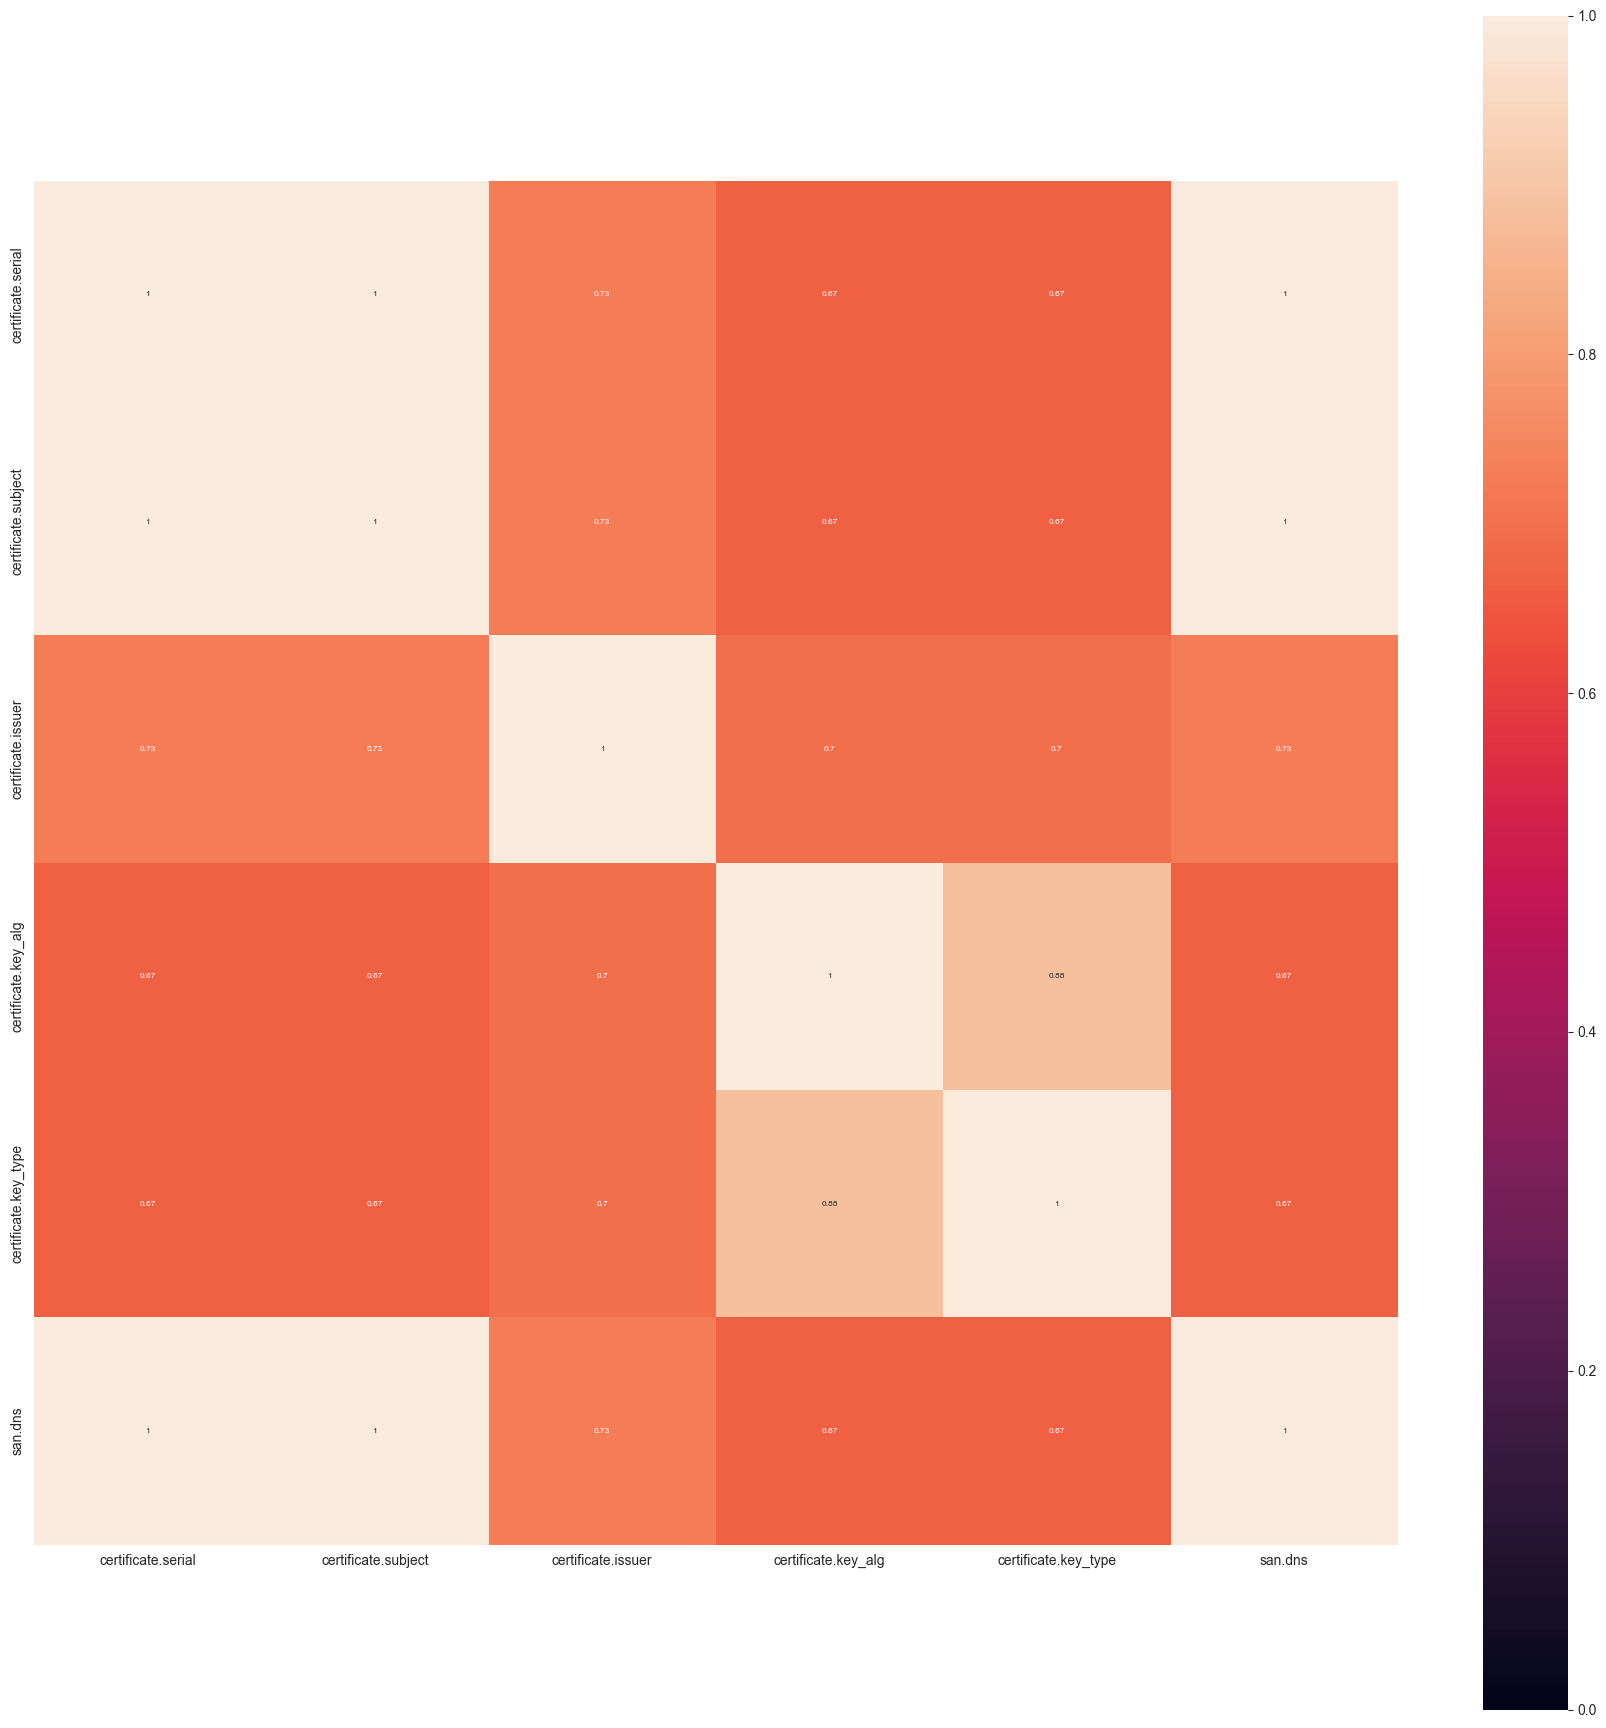

In [194]:
cramers_v_matrix,_ = generate_cramers_v_matrix(x509)

plt.figure(figsize=(22,22))
cramers_v_matrix.fillna(1, inplace=True)
cramers_v_matrix = cramers_v_matrix.drop(['id'], axis=1)
cramers_v_matrix = cramers_v_matrix.drop(['id'], axis=0)
sns.heatmap(cramers_v_matrix, annot=True, annot_kws={'size': 6}, vmin=0, vmax=1, square=True)

In [196]:
x509

,id,certificate.serial,certificate.issuer,certificate.not_valid_before,certificate.not_valid_after,certificate.key_alg
0,F11cB51wbjfFUg2Hqk,01C1AC2FB17829C72707395E7EF8CDB3,"CN=DigiCert SHA2 High Assurance Server CA,OU=w...",2020-07-20 22:00:00,2020-10-12 10:00:00,id-ecPublicKey
1,FGkGth3S2vgqsSOeW9,01C1AC2FB17829C72707395E7EF8CDB3,"CN=DigiCert SHA2 High Assurance Server CA,OU=w...",2020-07-20 22:00:00,2020-10-12 10:00:00,id-ecPublicKey
2,FU4lIF474GDFf2hycj,01C1AC2FB17829C72707395E7EF8CDB3,"CN=DigiCert SHA2 High Assurance Server CA,OU=w...",2020-07-20 22:00:00,2020-10-12 10:00:00,id-ecPublicKey
3,F5l1zD2OWAgyw4g1Y1,0CFE7DBF9D968839FD4820BD6FC8A30E,"CN=DigiCert SHA2 High Assurance Server CA,OU=w...",2020-03-04 23:00:00,2021-03-02 11:00:00,rsaEncryption
4,FrXiZ5fKhKL2s7Yv3,16000B42174A1FBE22833937FD0000000B4217,"CN=Microsoft IT TLS CA 4,OU=Microsoft IT,O=Mic...",2019-10-31 16:23:21,2021-10-31 16:23:21,rsaEncryption
5,F2IcbHptnvcAcsfob,16000B42174A1FBE22833937FD0000000B4217,"CN=Microsoft IT TLS CA 4,OU=Microsoft IT,O=Mic...",2019-10-31 16:23:21,2021-10-31 16:23:21,rsaEncryption
6,FQpYfl19rA6umwDOSi,0CFE7DBF9D968839FD4820BD6FC8A30E,"CN=DigiCert SHA2 High Assurance Server CA,OU=w...",2020-03-04 23:00:00,2021-03-02 11:00:00,rsaEncryption
7,F4SBJJ15cqRXrv00sf,20000CB511346DFD3F696B063B0000000CB511,"CN=Microsoft IT TLS CA 2,OU=Microsoft IT,O=Mic...",2019-11-06 11:57:50,2021-11-06 11:57:50,rsaEncryption
8,FMfUcS3fSKYPdQOK2,200010761A732AD90380310E1600000010761A,"CN=Microsoft IT TLS CA 2,OU=Microsoft IT,O=Mic...",2020-01-23 10:06:51,2022-01-23 10:06:51,rsaEncryption
9,FuYDgm3is2A70nZECe,200010761A732AD90380310E1600000010761A,"CN=Microsoft IT TLS CA 2,OU=Microsoft IT,O=Mic...",2020-01-23 10:06:51,2022-01-23 10:06:51,rsaEncryption


# 3. Data Labeling

In [197]:
"""Label the first 'benign_duration' minutes of traffic as benign."""

# Define the benign duration (4 minutes)
benign_duration = pd.Timedelta(minutes=4)  # 4 minutes in Timedelta

# Determine the start time
start_time = conn['ts'].min()

# Calculate the end time
end_time = start_time + benign_duration

# Label the traffic as 'benign' if it occurred within the first 4 minutes, otherwise 'malicious'
conn['is_malicious'] = np.where(conn['ts'] <= end_time, False, True)


In [198]:
conn

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,duration,conn_state,orig_ip_bytes,resp_ip_bytes,is_malicious
0,2020-09-02 14:33:23.796334982,CMLZbu3FDJYoZwa27k,10.8.0.117,1210,8.8.8.8,53,udp,0.010542,SF,59,108,False
1,2020-09-02 14:33:48.334928036,CgRCjV3z8dKmNVIvhb,10.8.0.117,43814,8.8.8.8,53,udp,0.010908,SF,61,115,False
2,2020-09-02 14:33:49.757675886,CgFfWv3PUApAZUINNf,10.8.0.117,51631,8.8.8.8,53,udp,0.010734,SF,78,94,False
3,2020-09-02 14:33:49.863610983,CIkFu02IznJPZcp1El,10.8.0.117,65449,8.8.8.8,53,udp,0.010405,SF,65,119,False
4,2020-09-02 14:33:51.540623903,Cylq6E2mc9lVLjs8ua,10.8.0.117,63247,8.8.8.8,53,udp,0.009332,SF,68,108,False
...,...,...,...,...,...,...,...,...,...,...,...,...
218,2020-09-02 15:27:20.320450068,CaStVq1Pbq8KOU84Ug,10.8.0.1,3,10.8.0.117,4,icmp,NaN,OTH,576,0,True
219,2020-09-02 15:27:20.300543070,CokYEW2q0cjgDIE5Gi,10.8.0.117,41360,104.244.42.66,443,tcp,300.203017,SF,7337,3017,True
220,2020-09-02 15:05:59.255357027,CYLKkn2Rnl8tV76MRi,10.8.0.117,47850,147.32.83.230,8000,tcp,1808.665546,RSTR,9156,7874,True
221,2020-09-02 15:31:50.362519026,CXYOR91l3zR6DkwXc4,10.8.0.117,57736,74.125.71.188,5228,tcp,0.063148,OTH,132,130,True


# 4. Data Merging

In [199]:
combined_features_conn = conn
combined_features_conn = combined_features_conn.merge(dns, on='uid', how='left', suffixes=('', '_dup'))
combined_features_conn = combined_features_conn.merge(ssl, on='uid', how='left', suffixes=('', '_dup'))
combined_features_conn = combined_features_conn.merge(http, on='uid', how='left', suffixes=('', '_dup'))
# combined_features = combined_features.loc[:, ~combined_features.columns.str.endswith('_dup')]

combined_features_conn

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,duration,conn_state,orig_ip_bytes,...,established,cert_chain_fuids,trans_depth,host,uri,request_body_len,response_body_len,status_code,status_msg,resp_fuids
0,2020-09-02 14:33:23.796334982,CMLZbu3FDJYoZwa27k,10.8.0.117,1210,8.8.8.8,53,udp,0.010542,SF,59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-09-02 14:33:48.334928036,CgRCjV3z8dKmNVIvhb,10.8.0.117,43814,8.8.8.8,53,udp,0.010908,SF,61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-09-02 14:33:49.757675886,CgFfWv3PUApAZUINNf,10.8.0.117,51631,8.8.8.8,53,udp,0.010734,SF,78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-09-02 14:33:49.863610983,CIkFu02IznJPZcp1El,10.8.0.117,65449,8.8.8.8,53,udp,0.010405,SF,65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-09-02 14:33:51.540623903,Cylq6E2mc9lVLjs8ua,10.8.0.117,63247,8.8.8.8,53,udp,0.009332,SF,68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,2020-09-02 15:27:20.320450068,CaStVq1Pbq8KOU84Ug,10.8.0.1,3,10.8.0.117,4,icmp,NaN,OTH,576,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
230,2020-09-02 15:27:20.300543070,CokYEW2q0cjgDIE5Gi,10.8.0.117,41360,104.244.42.66,443,tcp,300.203017,SF,7337,...,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231,2020-09-02 15:05:59.255357027,CYLKkn2Rnl8tV76MRi,10.8.0.117,47850,147.32.83.230,8000,tcp,1808.665546,RSTR,9156,...,NaN,NaN,1.0,147.32.83.230,/socket.io/?release=8.0.0&model=unknown&EIO=3&...,0.0,0.0,101.0,Switching Protocols,NaN
232,2020-09-02 15:31:50.362519026,CXYOR91l3zR6DkwXc4,10.8.0.117,57736,74.125.71.188,5228,tcp,0.063148,OTH,132,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [200]:
combined_features_files = files
combined_features_files = combined_features_files.merge(http, left_on='fuid', right_on='resp_fuids', how='left', suffixes=('', '_dup'))
combined_features_files = combined_features_files.merge(x509, left_on='fuid', right_on='id', how='left', suffixes=('', '_dup'))

columns_to_remove = ['resp_fuids', 'id', 'uid']
combined_features_files.drop(columns=columns_to_remove, inplace=True)
combined_features_files.rename(columns={'conn_uids': 'uid'}, inplace=True)
combined_features_files

,fuid,tx_hosts,rx_hosts,uid,source,analyzers,is_orig,seen_bytes,total_bytes,trans_depth,...,uri,request_body_len,response_body_len,status_code,status_msg,certificate.serial,certificate.issuer,certificate.not_valid_before,certificate.not_valid_after,certificate.key_alg
0,F11cB51wbjfFUg2Hqk,157.240.30.11,10.8.0.117,CYaRbd1LgVHyMi0os7,SSL,"SHA1,MD5,X509,SHA256",F,1579,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,01C1AC2FB17829C72707395E7EF8CDB3,"CN=DigiCert SHA2 High Assurance Server CA,OU=w...",2020-07-20 22:00:00,2020-10-12 10:00:00,id-ecPublicKey
1,FmMSzw1GvTD6uTW1d9,157.240.30.11,10.8.0.117,CYaRbd1LgVHyMi0os7,SSL,"SHA1,MD5,X509,SHA256",F,1205,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
2,FGkGth3S2vgqsSOeW9,157.240.30.34,10.8.0.117,CE2v1V1PiJwfenwq22,SSL,"SHA1,MD5,X509,SHA256",F,1579,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,01C1AC2FB17829C72707395E7EF8CDB3,"CN=DigiCert SHA2 High Assurance Server CA,OU=w...",2020-07-20 22:00:00,2020-10-12 10:00:00,id-ecPublicKey
3,FpI5qi1NT6HlRITfm4,157.240.30.34,10.8.0.117,CE2v1V1PiJwfenwq22,SSL,"SHA1,MD5,X509,SHA256",F,1205,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
4,FU4lIF474GDFf2hycj,69.171.250.20,10.8.0.117,CnCVN6i60NAbKmFxl,SSL,"SHA1,MD5,X509,SHA256",F,1579,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,01C1AC2FB17829C72707395E7EF8CDB3,"CN=DigiCert SHA2 High Assurance Server CA,OU=w...",2020-07-20 22:00:00,2020-10-12 10:00:00,id-ecPublicKey
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,FcPgxI2DlGsDq4Iooe,147.32.83.230,10.8.0.117,CUhwFI2YjMkHyGju97,HTTP,"SHA1,MD5",F,4,4.0,2.0,...,/socket.io/?release=8.0.0&model=unknown&EIO=3&...,0.0,4.0,200.0,OK,NaN,NaN,NaT,NaT,NaN
66,F0Jblz1wtu9YAE7sf8,10.8.0.117,147.32.83.230,CIrUMN3KNrQM1GRnU7,HTTP,"SHA1,MD5",T,4,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
67,FCuPUX3P4dyRQdf973,147.32.83.230,10.8.0.117,C9x7S83q8VCbuVz4wl,HTTP,"SHA1,MD5",F,101,101.0,1.0,...,/socket.io/?model=unknown&EIO=3&id=3ad69a3e675...,0.0,101.0,200.0,OK,NaN,NaN,NaT,NaT,NaN
68,FGApK81eAeQWObJDG6,147.32.83.230,10.8.0.117,C9x7S83q8VCbuVz4wl,HTTP,"SHA1,MD5",F,5,5.0,2.0,...,/socket.io/?release=8.0.0&model=unknown&EIO=3&...,0.0,5.0,200.0,OK,NaN,NaN,NaT,NaT,NaN


In [195]:
columns_to_remove = ['ts', 'certificate.subject', 'certificate.key_type', 'certificate.key_length', 'san.dns']
x509.drop(columns=columns_to_remove, inplace=True)

In [201]:
combined_features = combined_features_conn.merge(combined_features_files, on='uid', how='left', suffixes=('', '_dup'))

combined_features

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,duration,conn_state,orig_ip_bytes,...,uri_dup,request_body_len_dup,response_body_len_dup,status_code_dup,status_msg_dup,certificate.serial,certificate.issuer,certificate.not_valid_before,certificate.not_valid_after,certificate.key_alg
0,2020-09-02 14:33:23.796334982,CMLZbu3FDJYoZwa27k,10.8.0.117,1210,8.8.8.8,53,udp,0.010542,SF,59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
1,2020-09-02 14:33:48.334928036,CgRCjV3z8dKmNVIvhb,10.8.0.117,43814,8.8.8.8,53,udp,0.010908,SF,61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
2,2020-09-02 14:33:49.757675886,CgFfWv3PUApAZUINNf,10.8.0.117,51631,8.8.8.8,53,udp,0.010734,SF,78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
3,2020-09-02 14:33:49.863610983,CIkFu02IznJPZcp1El,10.8.0.117,65449,8.8.8.8,53,udp,0.010405,SF,65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
4,2020-09-02 14:33:51.540623903,Cylq6E2mc9lVLjs8ua,10.8.0.117,63247,8.8.8.8,53,udp,0.009332,SF,68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,2020-09-02 15:27:20.320450068,CaStVq1Pbq8KOU84Ug,10.8.0.1,3,10.8.0.117,4,icmp,NaN,OTH,576,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
292,2020-09-02 15:27:20.300543070,CokYEW2q0cjgDIE5Gi,10.8.0.117,41360,104.244.42.66,443,tcp,300.203017,SF,7337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
293,2020-09-02 15:05:59.255357027,CYLKkn2Rnl8tV76MRi,10.8.0.117,47850,147.32.83.230,8000,tcp,1808.665546,RSTR,9156,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
294,2020-09-02 15:31:50.362519026,CXYOR91l3zR6DkwXc4,10.8.0.117,57736,74.125.71.188,5228,tcp,0.063148,OTH,132,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN


In [202]:
combined_features['certificate.valid_duration'] = (combined_features['certificate.not_valid_after'] - combined_features['certificate.not_valid_before']).dt.total_seconds()
columns_to_remove = ['ts', 'certificate.not_valid_after', 'certificate.not_valid_before']
combined_features.drop(columns=columns_to_remove, inplace=True)
combined_features = combined_features.loc[:, ~combined_features.columns.str.endswith('_dup')]

# Count the number of categorical columns
num_categorical = combined_features.select_dtypes(include=['object', 'category']).shape[1]

# Count the number of numerical columns
num_numerical = combined_features.select_dtypes(include=[np.number]).shape[1]

# Print the counts
print(f"Number of categorical columns: {num_categorical}")
print(f"Number of numerical columns: {num_numerical}")

combined_features

Number of categorical columns: 27
Number of numerical columns: 13


,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,duration,conn_state,orig_ip_bytes,resp_ip_bytes,...,rx_hosts,source,analyzers,is_orig,seen_bytes,total_bytes,certificate.serial,certificate.issuer,certificate.key_alg,certificate.valid_duration
0,CMLZbu3FDJYoZwa27k,10.8.0.117,1210,8.8.8.8,53,udp,0.010542,SF,59,108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CgRCjV3z8dKmNVIvhb,10.8.0.117,43814,8.8.8.8,53,udp,0.010908,SF,61,115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CgFfWv3PUApAZUINNf,10.8.0.117,51631,8.8.8.8,53,udp,0.010734,SF,78,94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CIkFu02IznJPZcp1El,10.8.0.117,65449,8.8.8.8,53,udp,0.010405,SF,65,119,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Cylq6E2mc9lVLjs8ua,10.8.0.117,63247,8.8.8.8,53,udp,0.009332,SF,68,108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,CaStVq1Pbq8KOU84Ug,10.8.0.1,3,10.8.0.117,4,icmp,NaN,OTH,576,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292,CokYEW2q0cjgDIE5Gi,10.8.0.117,41360,104.244.42.66,443,tcp,300.203017,SF,7337,3017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
293,CYLKkn2Rnl8tV76MRi,10.8.0.117,47850,147.32.83.230,8000,tcp,1808.665546,RSTR,9156,7874,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
294,CXYOR91l3zR6DkwXc4,10.8.0.117,57736,74.125.71.188,5228,tcp,0.063148,OTH,132,130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [203]:
label_encoders = {}
for column in combined_features.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    combined_features[column] = le.fit_transform(combined_features[column])
    label_encoders[column] = le

C:\Users\tigro\AppData\Local\Temp\ipykernel_8244\1763224562.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_features[column] = le.fit_transform(combined_features[column])
C:\Users\tigro\AppData\Local\Temp\ipykernel_8244\1763224562.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_features[column] = le.fit_transform(combined_features[column])
C:\Users\tigro\AppData\Local\Temp\ipykernel_8244\1763224562.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

C:\Users\tigro\AppData\Local\Temp\ipykernel_8244\1180560669.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_features['is_malicious'] = combined_features['is_malicious'].astype(int)


<Axes: >

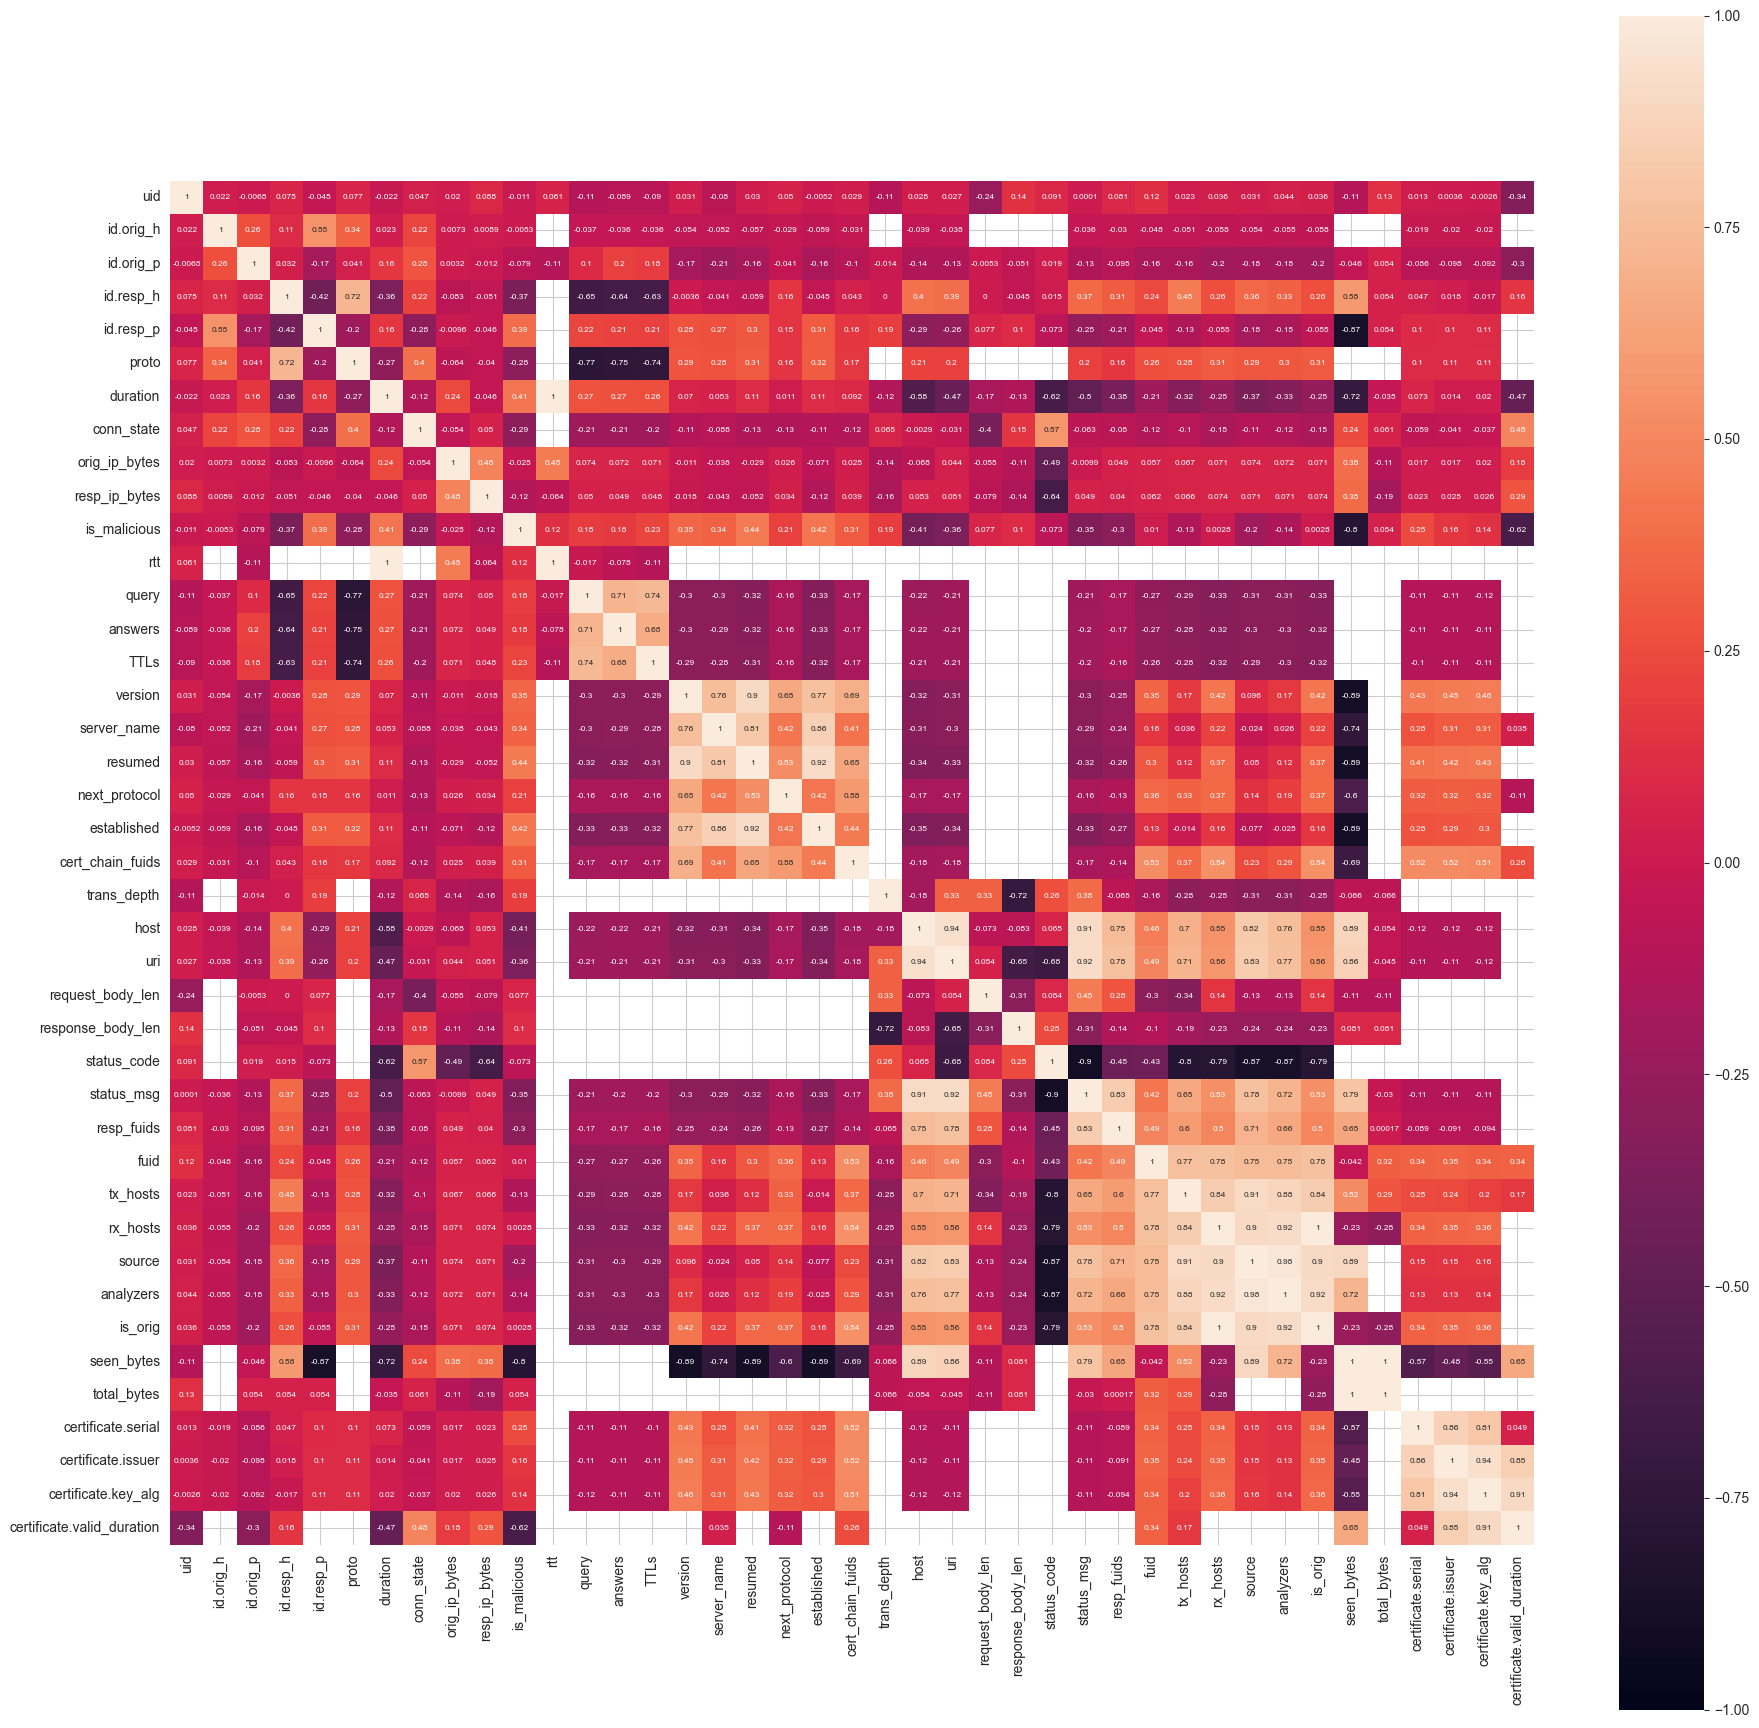

In [204]:
combined_features['is_malicious'] = combined_features['is_malicious'].astype(int)
correlation_matrix = combined_features.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(22,22))
sns.heatmap(correlation_matrix, annot=True, annot_kws={'size': 6}, vmin=-1, vmax=1, square=True)

In [205]:
combined_features.to_csv('../data/zeek_preprocessed/combined_features.csv', index=False)